In [1]:
# !pip install plotly
# !pip install matplotlib==3.5.0

In [2]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm, trange


import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import plotly.express as px
from difflib import SequenceMatcher
import seaborn as sns

In [3]:
def millions(x, pos):
    """The two args are the value and tick position."""
    return '{:1.1f}M'.format(x*1e-6)


In [4]:
all_data = pd.read_pickle('data/morbilidad_global.pkl')
all_data['IS_LIMA'] = all_data['PROVINCE'].apply(lambda x : True if x=='LIMA' else False)

In [5]:
len(set(all_data['DIAGNOSIS_ID'])), len(set(all_data['DISEASE']))

(32185, 8864)

In [6]:
all_data.head()

,DATE,YEAR,MONTH,STATE,PROVINCE,DISTRICT,SECTOR,CATEGORY,CATEGORY2,CO_IPRESS,...,DIAGNOSIS_ID,QTY_PEOPLE_SERVED,DISEASE,DISEASE_GROUP,COD_IPRESS,x,y,SECTOR_R,TYPE,IS_LIMA
0,2021-12-01,2021,12,JUNIN,TARMA,TARMA,GOBIERNO REGIONAL,I-1,0,00000590,...,S70.0,1,CONTUSION OF HIP,"Injuries, poisoning and some other consequence...",00000590,-11.449408,-75.664042,PUBLICO,Outpatient Consultation,False
1,2021-12-01,2021,12,JUNIN,TARMA,TARMA,GOBIERNO REGIONAL,I-1,0,00000590,...,N39.0,1,"URINARY TRACT INFECTION, SITE NOT SPECIFIED",Diseases of the genitourinary system,00000590,-11.449408,-75.664042,PUBLICO,Outpatient Consultation,False
2,2021-12-01,2021,12,JUNIN,TARMA,TARMA,GOBIERNO REGIONAL,I-1,0,00000590,...,M54.5,1,LOW BACK PAIN,Diseases of the musculoskeletal system and con...,00000590,-11.449408,-75.664042,PUBLICO,Outpatient Consultation,False
3,2021-12-01,2021,12,JUNIN,TARMA,TARMA,GOBIERNO REGIONAL,I-1,0,00000590,...,J06.9,2,"ACUTE UPPER RESPIRATORY INFECTION, UNSPECIFIED",Respiratory system diseases,00000590,-11.449408,-75.664042,PUBLICO,Outpatient Consultation,False
4,2021-12-01,2021,12,JUNIN,TARMA,TARMA,GOBIERNO REGIONAL,I-1,0,00000590,...,A64.X,1,UNIDENTIFIED,Some infectious and parasitic diseases,00000590,-11.449408,-75.664042,PUBLICO,Outpatient Consultation,False


In [7]:
data_temp = all_data.groupby(['DATE','DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE']).agg({ 'QTY_PEOPLE_SERVED': ['sum', 'count']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()
data_temp.head()

,DATE,sum,count
0,2015-01-01,6370,1010
1,2015-02-01,4303,837
2,2015-03-01,12568,917
3,2015-04-01,14378,1178
4,2015-05-01,16432,1284


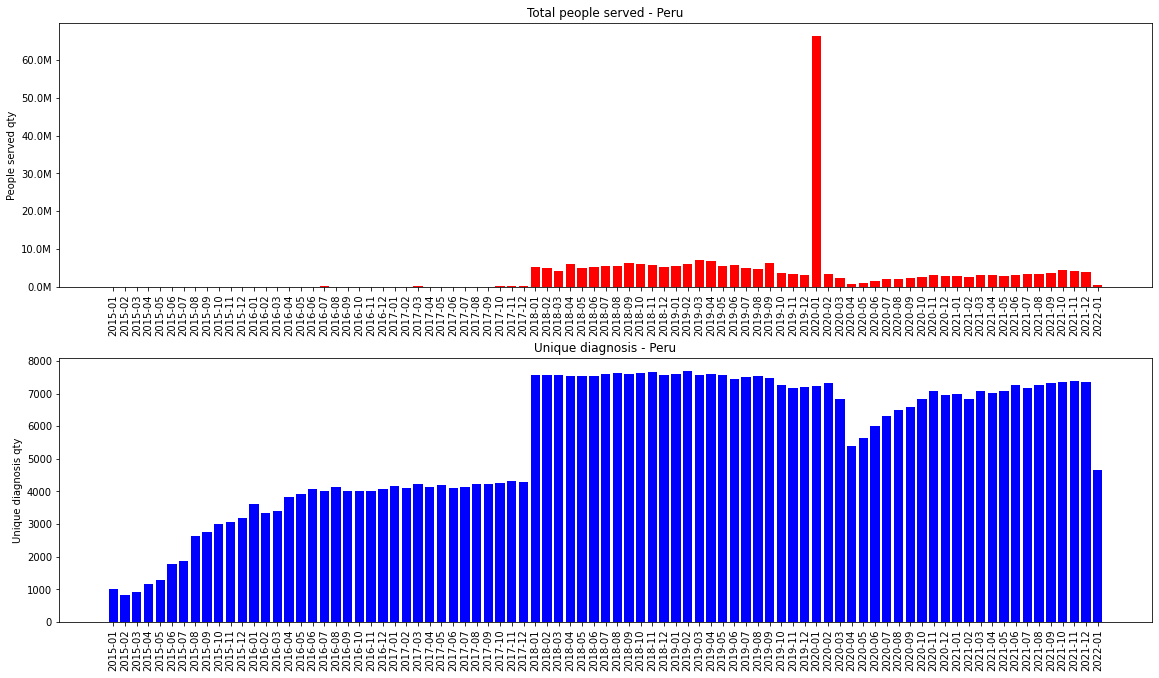

In [8]:
#fig, ax = plt.subplots(2, 1, figsize=(10,7))
fig, ax = plt.subplots(2, 1, figsize=(17,10))
fig.tight_layout(pad=5.0)

x = [str(item)[:7] for item in np.unique(data_temp['DATE'])]

y = list(data_temp['sum'])
ax[0].bar(x, y, color='red')
ax[0].set_ylabel('People served qty')
ax[0].set_title('Total people served - Peru')
ax[0].set_xticks(x)
ax[0].set_xticklabels(x, rotation=90)
ax[0].yaxis.set_major_formatter(millions)

y = list(data_temp['count'])
ax[1].bar(x, y, color='blue')
ax[1].set_ylabel('Unique diagnosis qty')
ax[1].set_title('Unique diagnosis - Peru')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, rotation=90)

fig.show()

In [9]:
all_data = all_data[all_data['YEAR']>=2018]
all_data['SECTOR2'] = all_data['SECTOR'].apply(lambda x: x if x == 'PRIVADO' else 'PUBLICO')

### Top 5 diagnosis - ALL PERU

In [10]:
PARAMETER = 'DISEASE_GROUP'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

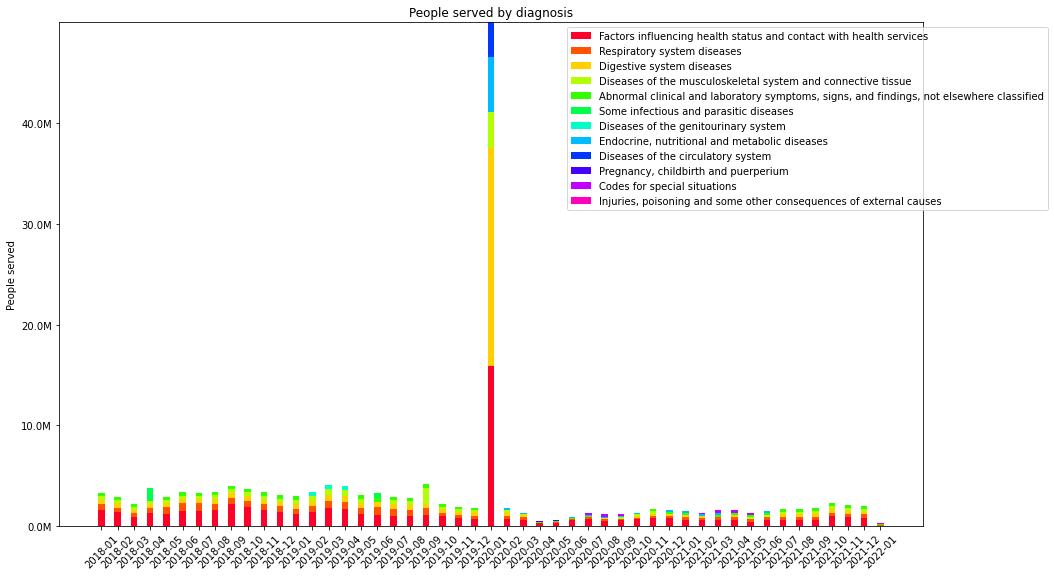

In [11]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

### Lima and Peru

In [12]:
PARAMETER = 'IS_LIMA'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

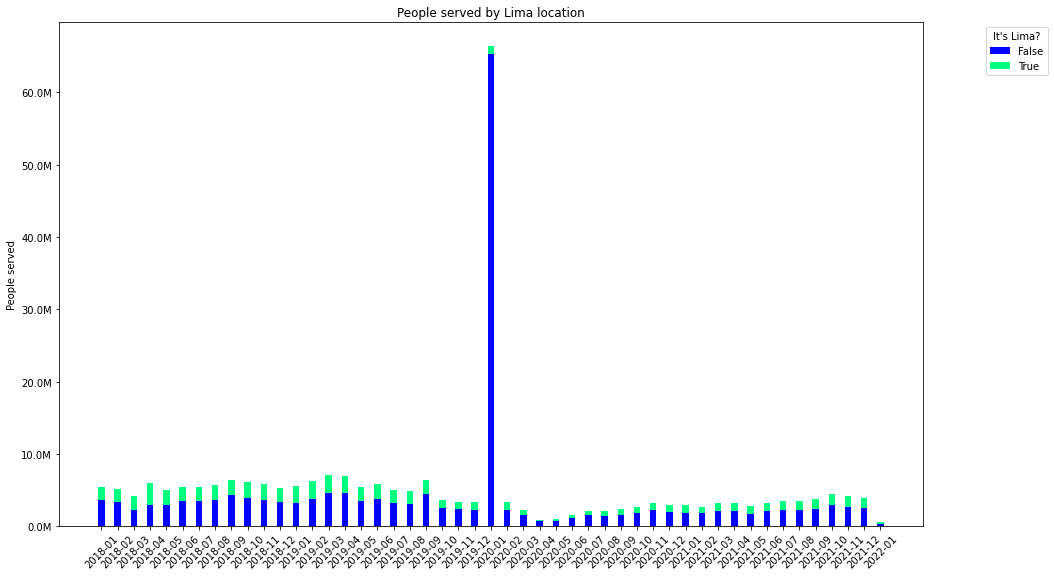

In [13]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "winter"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by Lima location')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1), title = "It's Lima?")
plt.show()

In [14]:
# ABC: verificar si HAY DUPLICADOS EN PROVIONCIAS EN ENERO 20

#### Lima vs Provinces (by year)

data_temp.plot(kind="bar", stacked=True)

### Births in Peru (by month)

# Only Lima

In [15]:
all_data = pd.read_pickle('data/morbilidad_global_lima.pkl')

In [16]:
diagnostics_tag = np.unique(all_data['DISEASE_GROUP'])

cmap = cm.get_cmap('tab20b', 256)
colorsb = cmap(np.linspace(0, 1, 20))
cmap = cm.get_cmap('tab20c', 256)
colorsc = cmap(np.linspace(0, 1, 20))[8:-4]

colors = list(colorsc)+list(colorsb)
dict_colors = {}
counter = 0
for d in diagnostics_tag:
    x=colors[counter]
    dict_colors[d]=matplotlib.colors.rgb2hex(x)
    counter+=1

In [17]:
data_temp = all_data.groupby(['DATE','DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE']).agg({ 'QTY_PEOPLE_SERVED': ['sum', 'count']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()

data_temp = data_temp.rename(columns={'sum': 'People_served', 'count': 'Unique_diagnosis'})

### Outlayers

/home/mnunez/.conda/envs/pycaret_ts/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mnunez/.conda/envs/pycaret_ts/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


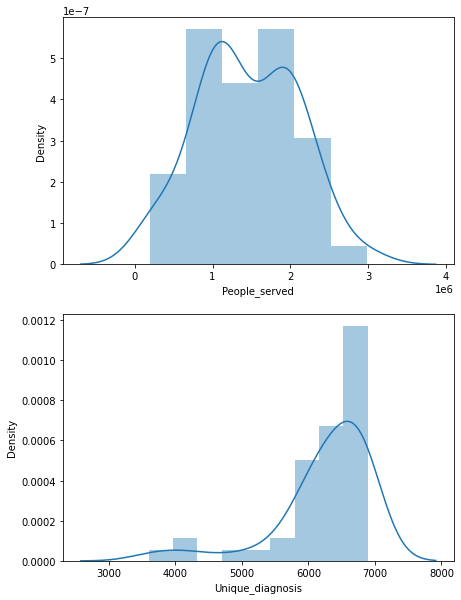

In [18]:
plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
sns.distplot(data_temp['People_served'])
plt.subplot(2,1,2)
sns.distplot(data_temp['Unique_diagnosis'])
plt.show()

In [19]:
print(' People served')
people_served_max = data_temp['People_served'].mean() + 1*data_temp['People_served'].std()
people_served_min = data_temp['People_served'].mean() - 1*data_temp['People_served'].std()
print("   Highest allowed", people_served_max)
print("   Lowest allowed", people_served_min)
print()
print(' Unique diagnosis')
unique_diagnosis_max = data_temp['Unique_diagnosis'].mean() + 1*data_temp['Unique_diagnosis'].std()
unique_diagnosis_min = data_temp['Unique_diagnosis'].mean() - 1*data_temp['Unique_diagnosis'].std()
print("   Highest allowed", unique_diagnosis_max)
print("   Lowest allowed", unique_diagnosis_min)

data_temp['ps_out'] = data_temp['People_served'].apply(lambda x : 
                                                       0 if (people_served_min>x or
                                                                people_served_max<x)  
                                                       else x)
data_temp['ud_out'] = data_temp['Unique_diagnosis'].apply(lambda x : 
                                                       0 if (unique_diagnosis_min>x or
                                                                unique_diagnosis_max<x)  
                                                       else x )


 People served
   Highest allowed 2096462.6018830189
   Lowest allowed 805568.2144435118

 Unique diagnosis
   Highest allowed 6983.687152439192
   Lowest allowed 5500.4352965404


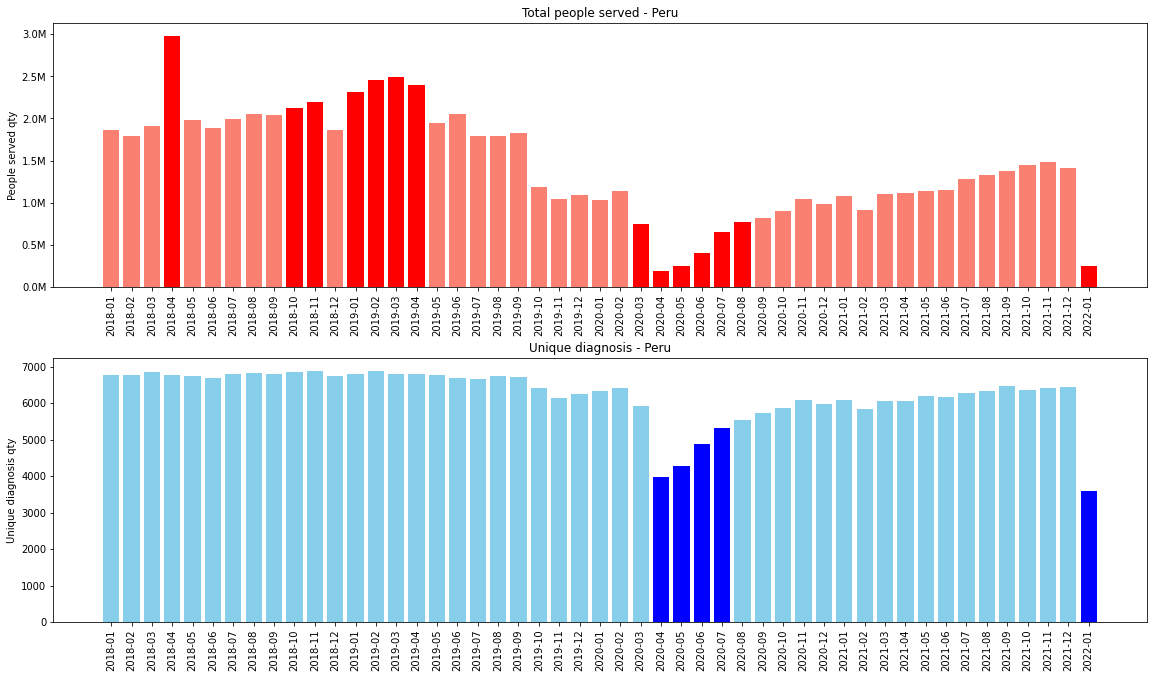

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(17,10))
fig.tight_layout(pad=5.0)

x = [str(item)[:7] for item in np.unique(data_temp['DATE'])]

y = list(data_temp['People_served'])
ax[0].bar(x, y, color='red')
y = list(data_temp['ps_out'])
ax[0].bar(x, y, color='salmon')
ax[0].set_ylabel('People served qty')
ax[0].set_title('Total people served - Peru')
ax[0].set_xticks(x)
ax[0].set_xticklabels(x, rotation=90)
ax[0].yaxis.set_major_formatter(millions)

y = list(data_temp['Unique_diagnosis'])
ax[1].bar(x, y, color='blue')
y = list(data_temp['ud_out'])
ax[1].bar(x, y, color='skyblue')
ax[1].set_ylabel('Unique diagnosis qty')
ax[1].set_title('Unique diagnosis - Peru')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, rotation=90)

fig.show()

### Top 10 diagnosis 

In [21]:
PARAMETER = 'DISEASE_GROUP'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    #temp_df = temp_df.head(10).reset_index(drop=True)
    temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

Sanity check for IHM using respiratory deseases. In IHM profile respiratory desease is 8% for Peru while in our Lima dataset we have arronf 9%


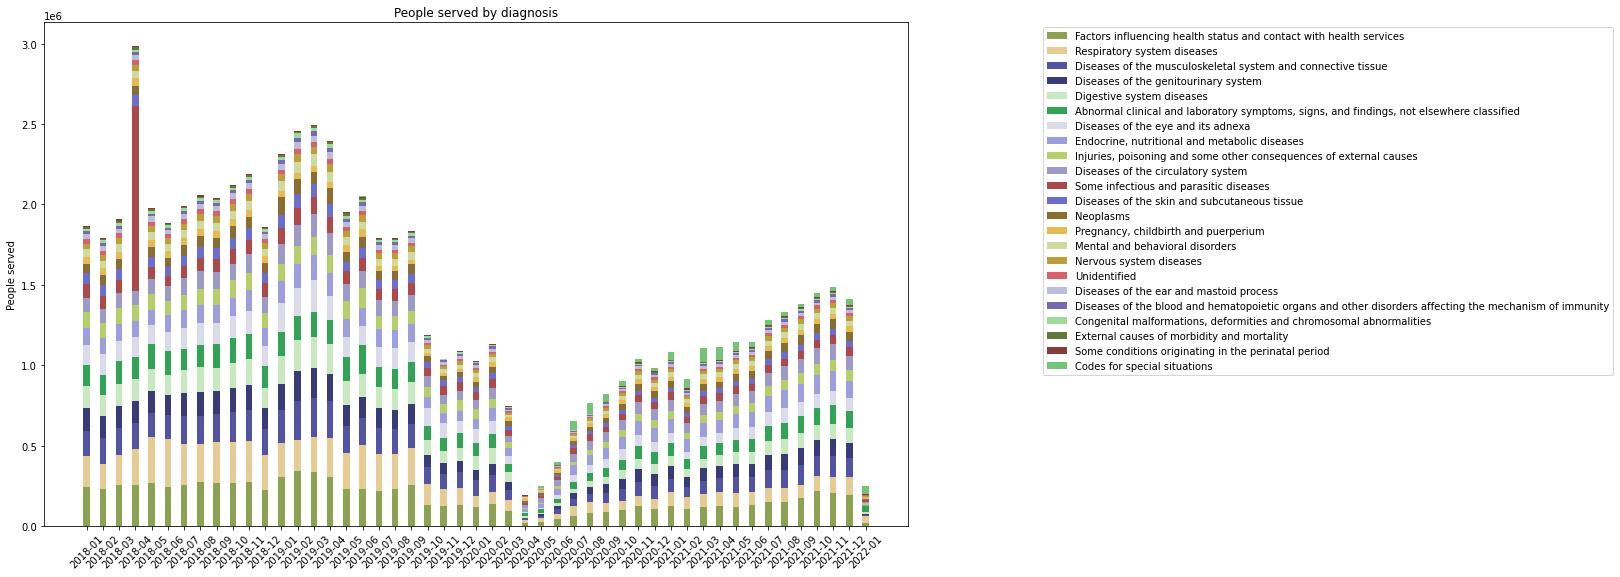

In [22]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=dict_colors[diag])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45) 

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

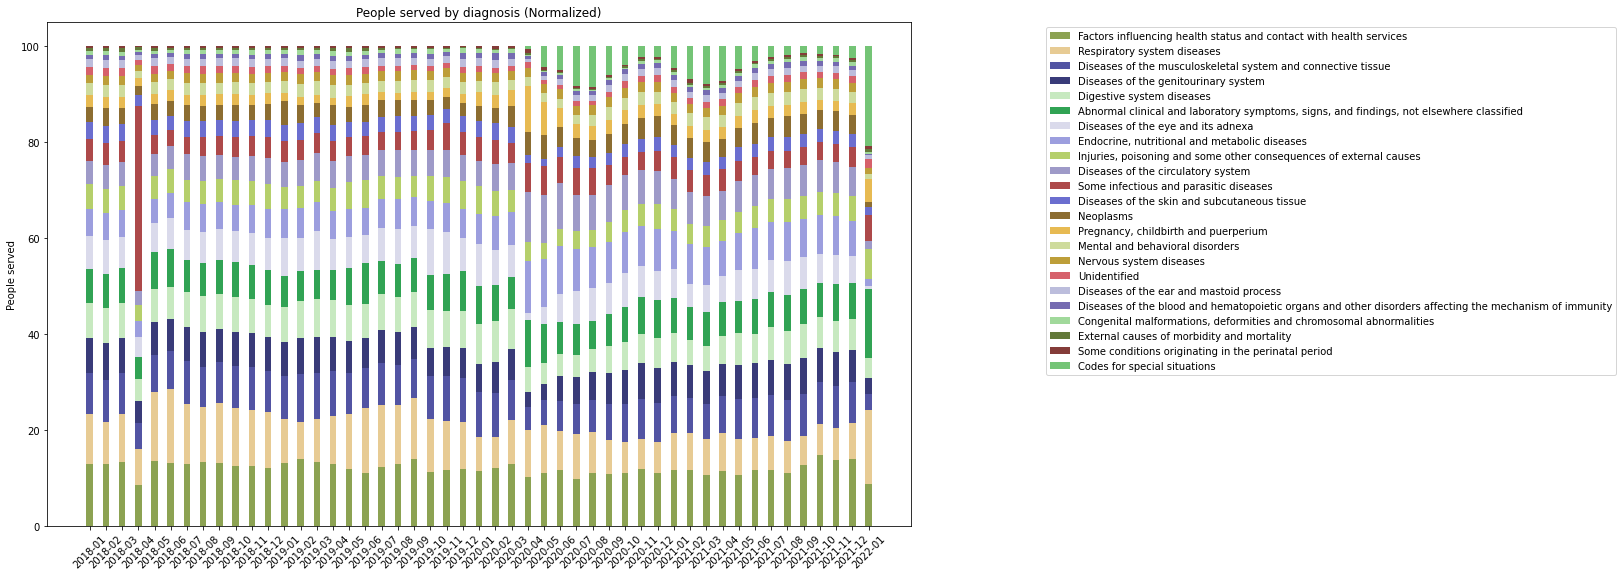

In [23]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['PER'].values
    ax.bar(ind, values, width, bottom=values_temp, color=dict_colors[diag])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis (Normalized)')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

### Births in Lima (by month)

Revisar datos de natalidad

### Morbidity type

In [24]:
PARAMETER = 'TYPE'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

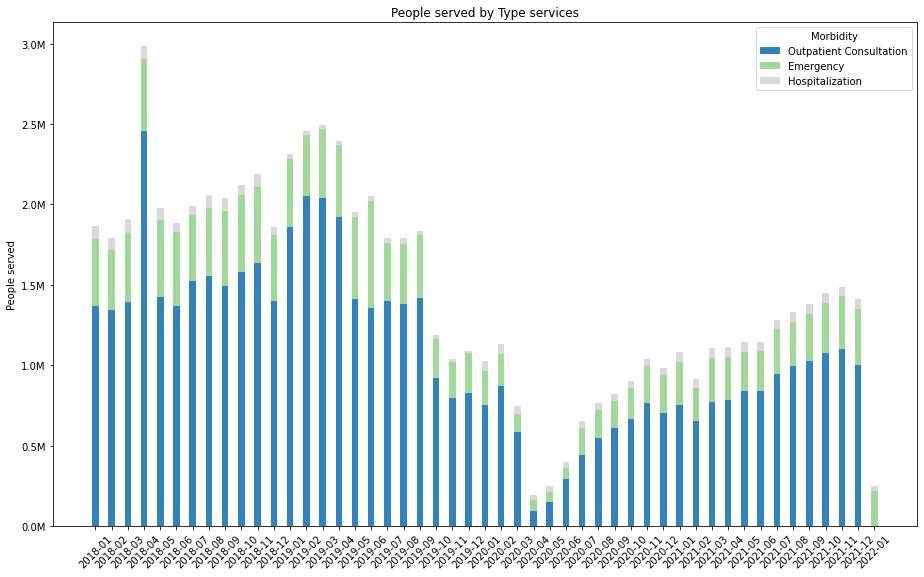

In [25]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "tab20c"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by Type services')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1., 1), title = "Morbidity")
plt.show()

### Diagnoses qty by hospitals and hospital category

In [26]:
data_temp = all_data[all_data['CATEGORY2']!='ABC']
data_temp = data_temp.groupby(['DATE','CATEGORY2','DIAGNOSIS_ID']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE','CATEGORY2']).agg({ 'QTY_PEOPLE_SERVED': "count"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['DATE'].unique()
category2 = data_temp['CATEGORY2'].unique()

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    category2_temp = list(set(category2) - set(temp_df['CATEGORY2'].values))
    temp_df = pd.DataFrame(category2_temp, columns =['CATEGORY2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp = pd.concat([data_temp, temp_df])

data_temp = data_temp.sort_values(by=['DATE','CATEGORY2'], ascending=True)

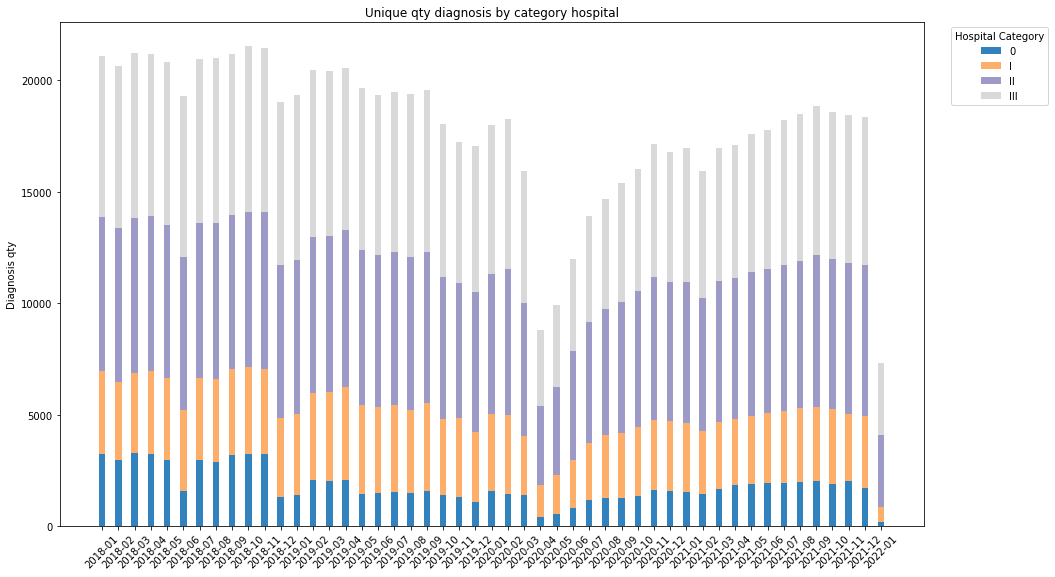

In [27]:
PARAMETER_COL = 'CATEGORY2'

category2 = data_temp[PARAMETER_COL].unique()
x_element = [str(item)[:7] for item in np.unique(data_temp['DATE'])]
N = len(x_element)
ind = np.arange(N) 
width = 0.40

name = "tab20c"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(category2)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for p in category2:
    temp_df = data_temp[data_temp[PARAMETER_COL]==p]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('Diagnosis qty')
ax.set_title('Unique qty diagnosis by category hospital')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=category2, bbox_to_anchor = (1.15, 1), title = "Hospital Category")
plt.show()

### Diagnoses qty per hospital category (by year)

## People qty by hospitals and hospital category

In [28]:
data_temp = all_data[all_data['CATEGORY2']!='ABC']
# data_temp = data_temp.groupby(['DATE','CATEGORY2','DIAGNOSIS_ID']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
# data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE','CATEGORY2']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['DATE'].unique()
category2 = data_temp['CATEGORY2'].unique()

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    category2_temp = list(set(category2) - set(temp_df['CATEGORY2'].values))
    temp_df = pd.DataFrame(category2_temp, columns =['CATEGORY2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp = pd.concat([data_temp, temp_df])

data_temp = data_temp.sort_values(by=['DATE','CATEGORY2'], ascending=True)

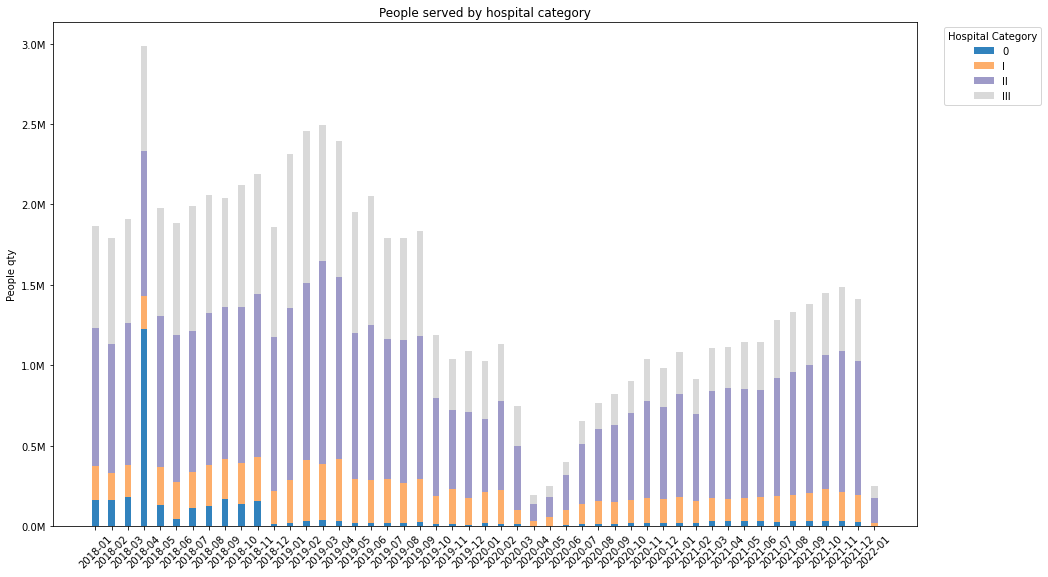

In [29]:
PARAMETER_COL = 'CATEGORY2'

category2 = data_temp[PARAMETER_COL].unique()
x_element = [str(item)[:7] for item in np.unique(data_temp['DATE'])]
N = len(x_element)
ind = np.arange(N) 
width = 0.40

name = "tab20c"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(category2)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for p in category2:
    temp_df = data_temp[data_temp[PARAMETER_COL]==p]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People qty')
ax.set_title('People served by hospital category')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=category2, bbox_to_anchor = (1.15, 1), title = "Hospital Category")
plt.show()

In [30]:
data_temp = all_data[all_data['CATEGORY2']!='ABC']
data_temp = data_temp.groupby(['DATE','CATEGORY2','DIAGNOSIS_ID']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE','CATEGORY2']).agg({ 'QTY_PEOPLE_SERVED': "count"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['DATE'].unique()
category2 = data_temp['CATEGORY2'].unique()

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    category2_temp = list(set(category2) - set(temp_df['CATEGORY2'].values))
    temp_df = pd.DataFrame(category2_temp, columns =['CATEGORY2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp = pd.concat([data_temp, temp_df])

data_temp_dq = data_temp.sort_values(by=['DATE','CATEGORY2'], ascending=True)
data_temp_dq = data_temp_dq.rename(columns={"QTY_PEOPLE_SERVED": "Diagnosis qty"})

data_temp = all_data[all_data['CATEGORY2']!='ABC']
# data_temp = data_temp.groupby(['DATE','CATEGORY2','DIAGNOSIS_ID']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
# data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE','CATEGORY2']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['DATE'].unique()
category2 = data_temp['CATEGORY2'].unique()

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    category2_temp = list(set(category2) - set(temp_df['CATEGORY2'].values))
    temp_df = pd.DataFrame(category2_temp, columns =['CATEGORY2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp = pd.concat([data_temp, temp_df])

data_temp_ps = data_temp.sort_values(by=['DATE','CATEGORY2'], ascending=True)
data_temp_ps = data_temp_ps.rename(columns={"QTY_PEOPLE_SERVED": "People served"})

/tmp/ipykernel_163925/3555594971.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_p['out'] = data_temp_p['People served'].apply(lambda x :
/tmp/ipykernel_163925/3555594971.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_d['out'] = data_temp_d['Diagnosis qty'].apply(lambda x :
/home/mnunez/.conda/envs/pycaret_ts/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

<AxesSubplot:xlabel='Diagnosis qty', ylabel='Density'>

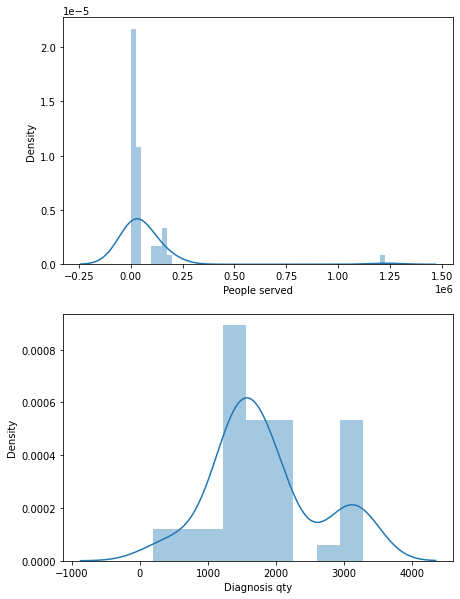

In [31]:
#### Categoria 0

Ctgy_std = '0'
data_temp_p = data_temp_ps[data_temp_ps['CATEGORY2']==Ctgy_std]
data_temp_d = data_temp_dq[data_temp_dq['CATEGORY2']==Ctgy_std]


people_served_max = data_temp_p['People served'].mean() + 1*data_temp_p['People served'].std()
people_served_min = data_temp_p['People served'].mean() - 1*data_temp_p['People served'].std()
unique_diagnosis_max = data_temp_d['Diagnosis qty'].mean() + 1*data_temp_d['Diagnosis qty'].std()
unique_diagnosis_min = data_temp_d['Diagnosis qty'].mean() - 1*data_temp_d['Diagnosis qty'].std()

data_temp_p['out'] = data_temp_p['People served'].apply(lambda x : 
                                                           0 if (people_served_min>x or
                                                                 people_served_max<x)
                                                           else x)

data_temp_d['out'] = data_temp_d['Diagnosis qty'].apply(lambda x : 
                                                           0 if (unique_diagnosis_min>x or
                                                                 unique_diagnosis_max<x)
                                                           else x)

plt.figure(figsize=(7,10))

plt.subplot(2,1,1)
sns.distplot(data_temp_p['People served'])
plt.subplot(2,1,2)
sns.distplot(data_temp_d['Diagnosis qty'])

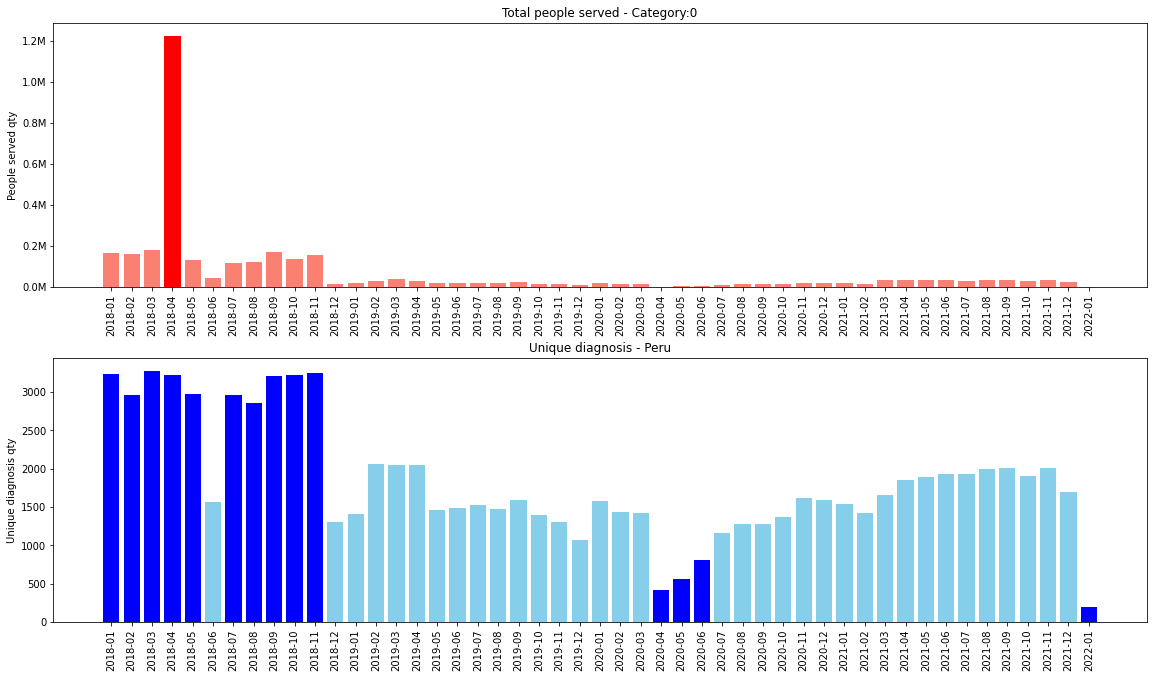

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(17,10))
fig.tight_layout(pad=5.0)

x = [str(item)[:7] for item in np.unique(data_temp_p['DATE'])]

y = list(data_temp_p['People served'])
ax[0].bar(x, y, color='red')
y = list(data_temp_p['out'])
ax[0].bar(x, y, color='salmon')
ax[0].set_ylabel('People served qty')
ax[0].set_title('Total people served - Category:'+Ctgy_std)
ax[0].set_xticks(x)
ax[0].set_xticklabels(x, rotation=90)
ax[0].yaxis.set_major_formatter(millions)

y = list(data_temp_d['Diagnosis qty'])
ax[1].bar(x, y, color='blue')
y = list(data_temp_d['out'])
ax[1].bar(x, y, color='skyblue')
ax[1].set_ylabel('Unique diagnosis qty')
ax[1].set_title('Unique diagnosis - Peru')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, rotation=90)

fig.show()

#### Diagnosis to Cat 0

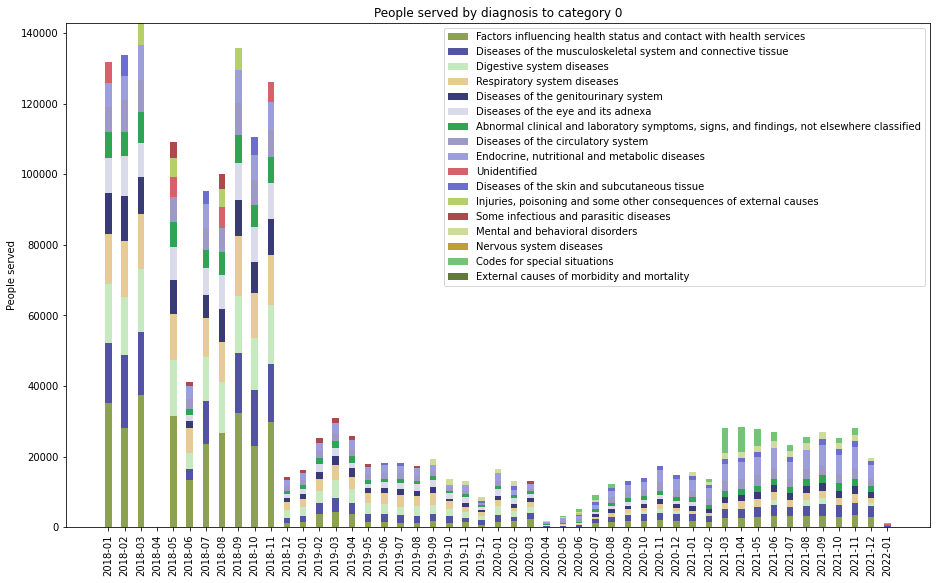

In [33]:
data_temp = all_data[all_data['CATEGORY2']==Ctgy_std]

PARAMETER = 'DISEASE_GROUP'

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    #temp_df = temp_df.reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)


top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=dict_colors[diag])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis to category '+Ctgy_std)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.0, 1))
plt.show()

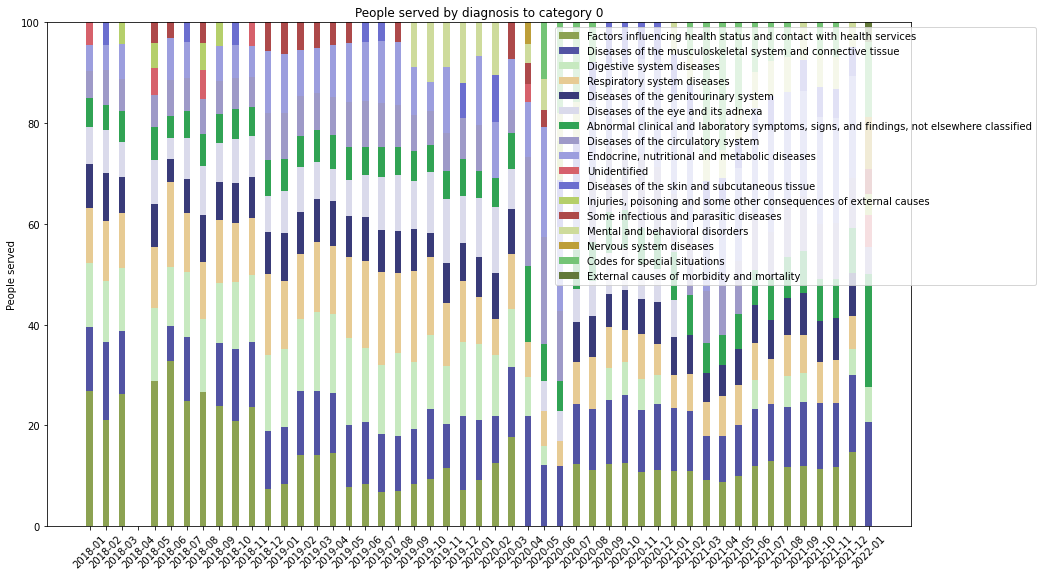

In [34]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['PER'].values
    ax.bar(ind, values, width, bottom=values_temp, color=dict_colors[diag])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis to category '+Ctgy_std)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1), loc=1)
plt.show()

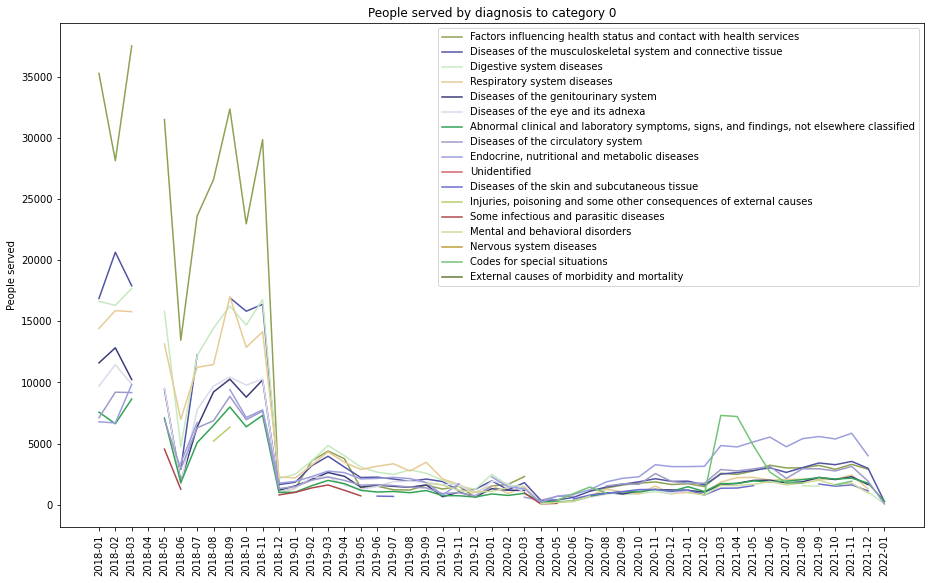

In [35]:

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    temp_df = temp_df.replace(0, np.nan)
    
    values = temp_df['QTY_PEOPLE_SERVED'].values
    #values = temp_df['PER'].values
    
    ax.plot(values, color=dict_colors[diag], label=diag)
    values_temp = values_temp + values
    i+=1
    
ax.set_ylabel('People served')
ax.set_title('People served by diagnosis to category '+Ctgy_std)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.0, 1))
plt.show()


#### Diagnosis to Cat 0 - sector2

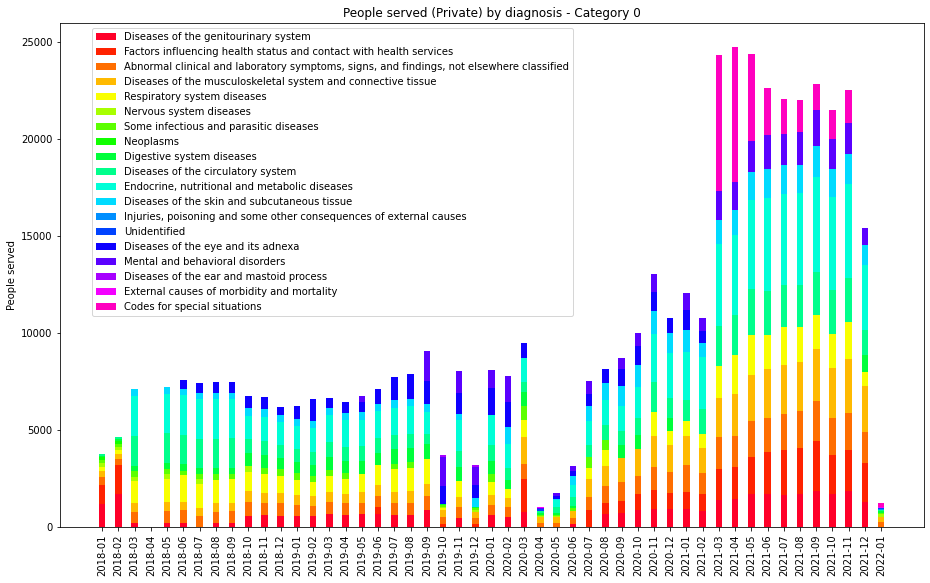

In [36]:
data_temp = all_data[all_data['CATEGORY2']==Ctgy_std]
data_temp = data_temp[data_temp['SECTOR']=='PRIVADO']

PARAMETER = 'DISEASE_GROUP'

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served (Private) by diagnosis - Category '+Ctgy_std)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (0.6, 1))
plt.show()

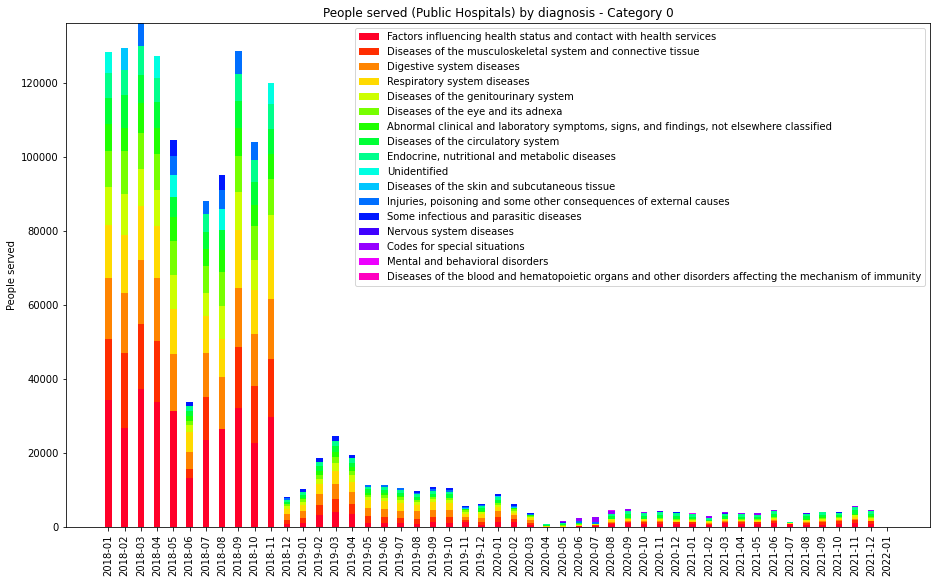

In [37]:
data_temp = all_data[all_data['CATEGORY2']==Ctgy_std]
data_temp = data_temp[~(data_temp['SECTOR']=='PRIVADO')]

PARAMETER = 'DISEASE_GROUP'

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

# top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
# top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served (Public Hospitals) by diagnosis - Category '+Ctgy_std)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1., 1))
plt.show()

/tmp/ipykernel_163925/1081730851.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_p['out'] = data_temp_p['People served'].apply(lambda x :
/tmp/ipykernel_163925/1081730851.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_d['out'] = data_temp_d['Diagnosis qty'].apply(lambda x :
/home/mnunez/.conda/envs/pycaret_ts/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

<AxesSubplot:xlabel='Diagnosis qty', ylabel='Density'>

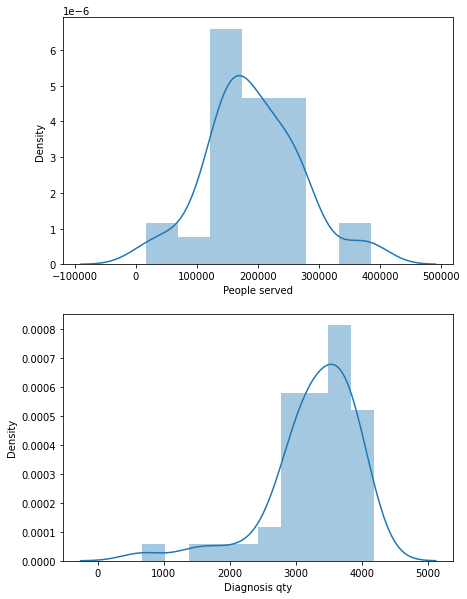

In [38]:
#### Categoria 1

Ctgy_std = 'I'
data_temp_p = data_temp_ps[data_temp_ps['CATEGORY2']==Ctgy_std]
data_temp_d = data_temp_dq[data_temp_dq['CATEGORY2']==Ctgy_std]


people_served_max = data_temp_p['People served'].mean() + 1*data_temp_p['People served'].std()
people_served_min = data_temp_p['People served'].mean() - 1*data_temp_p['People served'].std()
unique_diagnosis_max = data_temp_d['Diagnosis qty'].mean() + 1*data_temp_d['Diagnosis qty'].std()
unique_diagnosis_min = data_temp_d['Diagnosis qty'].mean() - 1*data_temp_d['Diagnosis qty'].std()

data_temp_p['out'] = data_temp_p['People served'].apply(lambda x : 
                                                           0 if (people_served_min>x or
                                                                 people_served_max<x)
                                                           else x)

data_temp_d['out'] = data_temp_d['Diagnosis qty'].apply(lambda x : 
                                                           0 if (unique_diagnosis_min>x or
                                                                 unique_diagnosis_max<x)
                                                           else x)

plt.figure(figsize=(7,10))

plt.subplot(2,1,1)
sns.distplot(data_temp_p['People served'])
plt.subplot(2,1,2)
sns.distplot(data_temp_d['Diagnosis qty'])

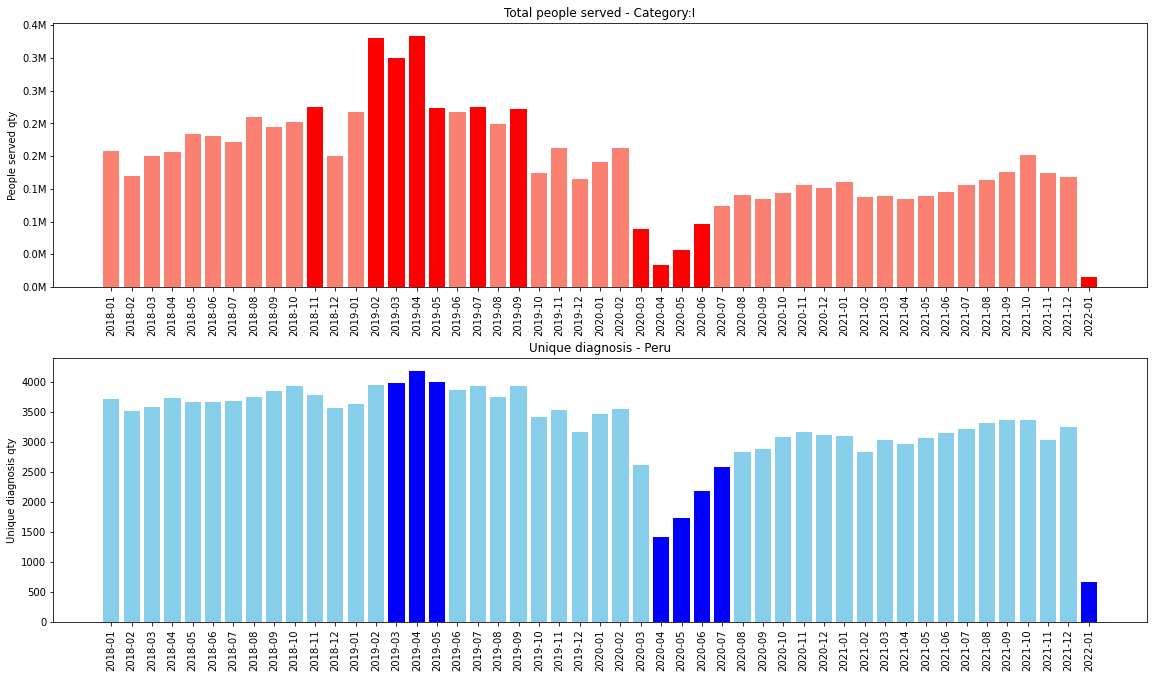

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(17,10))
fig.tight_layout(pad=5.0)

x = [str(item)[:7] for item in np.unique(data_temp_p['DATE'])]

y = list(data_temp_p['People served'])
ax[0].bar(x, y, color='red')
y = list(data_temp_p['out'])
ax[0].bar(x, y, color='salmon')
ax[0].set_ylabel('People served qty')
ax[0].set_title('Total people served - Category:'+Ctgy_std)
ax[0].set_xticks(x)
ax[0].set_xticklabels(x, rotation=90)
ax[0].yaxis.set_major_formatter(millions)

y = list(data_temp_d['Diagnosis qty'])
ax[1].bar(x, y, color='blue')
y = list(data_temp_d['out'])
ax[1].bar(x, y, color='skyblue')
ax[1].set_ylabel('Unique diagnosis qty')
ax[1].set_title('Unique diagnosis - Peru')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, rotation=90)

fig.show()

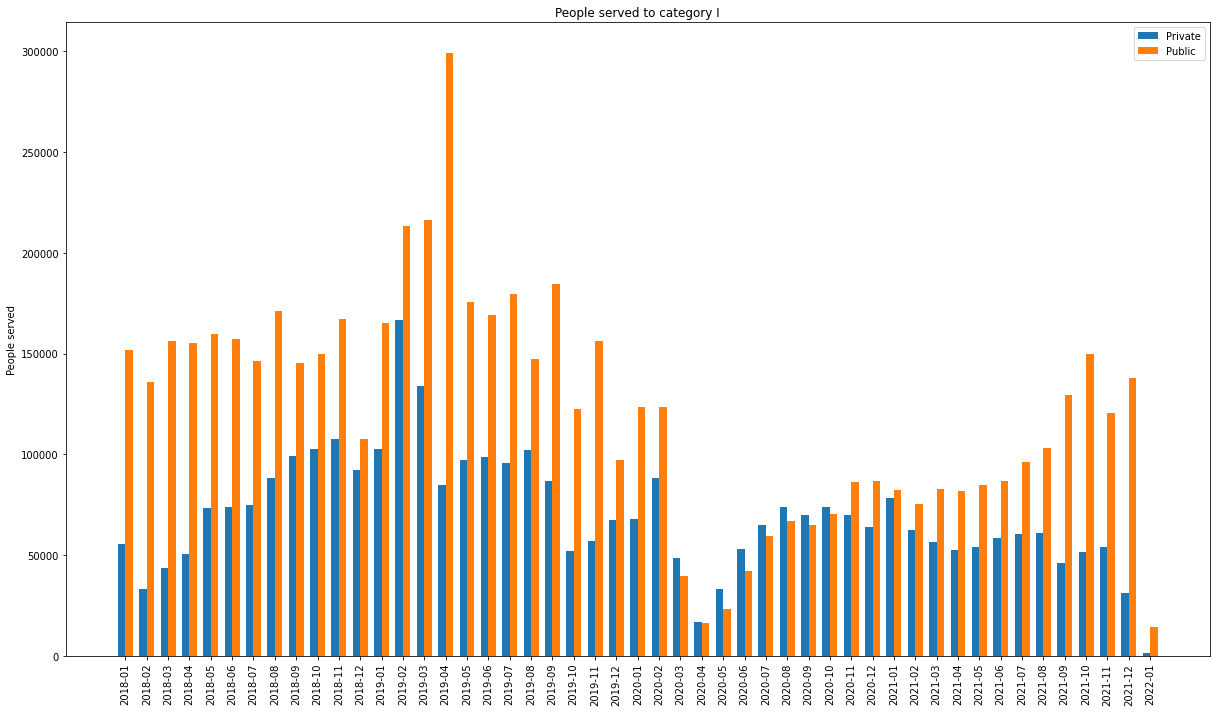

In [40]:
data_temp = all_data[all_data['CATEGORY2']==Ctgy_std]
data_temp = data_temp.groupby(['DATE','SECTOR2']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

# data_temp['QTY_PEOPLE_SERVED'] = data_temp['QTY_PEOPLE_SERVED'].mask(
#     (data_temp['DATE'].dt.year==2018) & (data_temp['DATE'].dt.month==4), 0)



date_uniques = data_temp['DATE'].unique()
data_temp_privado = data_temp[data_temp['SECTOR2']=='PRIVADO']
data_temp_publico = data_temp[data_temp['SECTOR2']=='PUBLICO']


dimension = data_temp_privado['SECTOR2'].unique()
for date in date_uniques:
    temp_df = data_temp_privado[data_temp_privado['DATE']==date]
    dimension_temp = list(set(dimension) - set(temp_df['SECTOR2'].values))
    temp_df = pd.DataFrame(dimension_temp, columns =['SECTOR2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp_privado = pd.concat([data_temp_privado, temp_df])

    
dimension = data_temp_publico['SECTOR2'].unique()
for date in date_uniques:
    temp_df = data_temp_publico[data_temp_publico['DATE']==date]
    dimension_temp = list(set(dimension) - set(temp_df['SECTOR2'].values))
    temp_df = pd.DataFrame(dimension_temp, columns =['SECTOR2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp_publico = pd.concat([data_temp_publico, temp_df])

data_temp_privado = data_temp_privado.sort_values(by=['DATE','SECTOR2'], ascending=True)
data_temp_publico = data_temp_publico.sort_values(by=['DATE','SECTOR2'], ascending=True)


labels = [str(x)[:7] for x in date_uniques]
privado_means = list(data_temp_privado['QTY_PEOPLE_SERVED'])
publico_means = list(data_temp_publico['QTY_PEOPLE_SERVED'])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

#fig, ax = plt.subplots()
fig, ax = plt.subplots(1, 1, figsize=(17,10))
rects1 = ax.bar(x - width/2, privado_means, width, label='Private')
rects2 = ax.bar(x + width/2, publico_means, width, label='Public')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('People served')
ax.set_title('People served to category '+Ctgy_std)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

#ax.yaxis.set_major_formatter(millions)

plt.show()

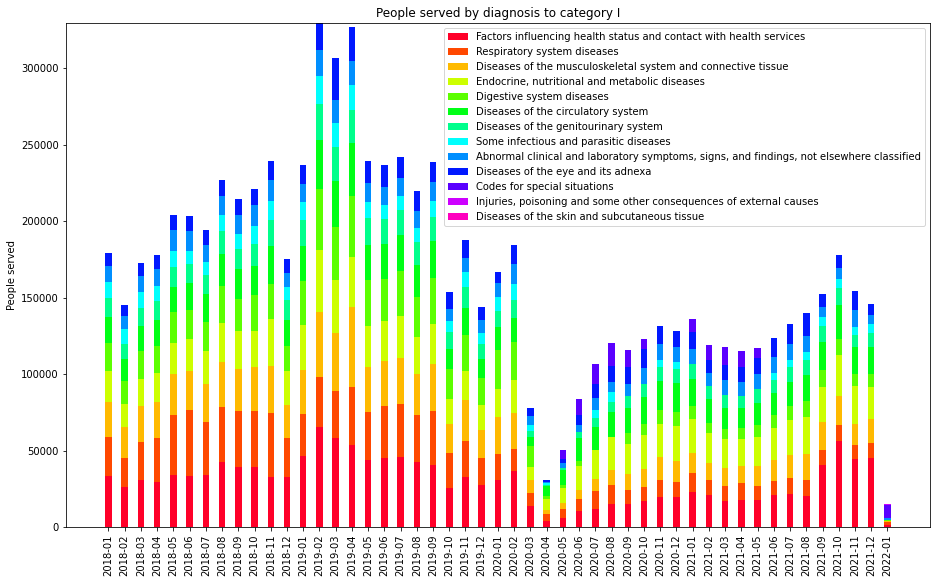

In [41]:
data_temp = all_data[all_data['CATEGORY2']==Ctgy_std]

PARAMETER = 'DISEASE_GROUP'

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    #temp_df = temp_df.reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)


# top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
# top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis to category '+Ctgy_std)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.0, 1))
plt.show()

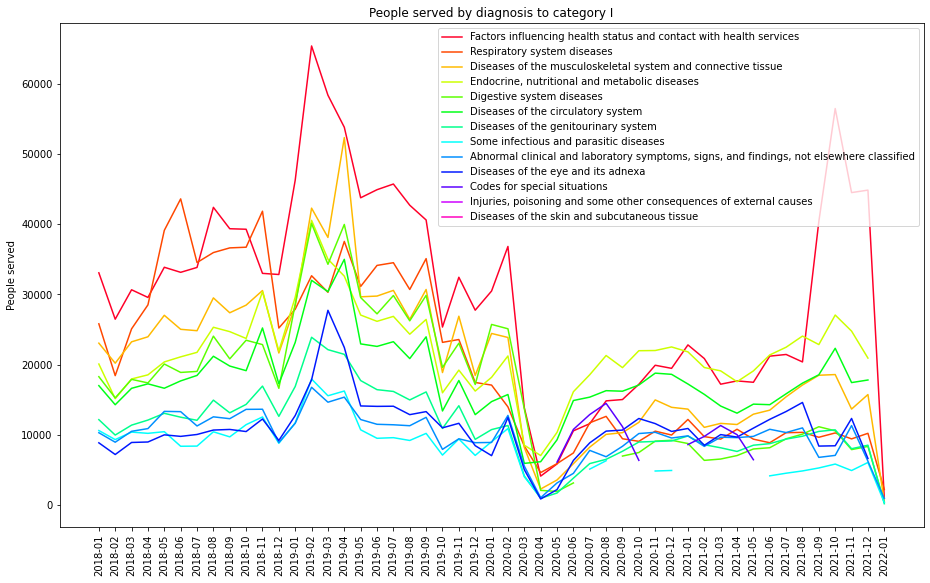

In [42]:

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])


values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    temp_df = temp_df.replace(0, np.nan)
    
    values = temp_df['QTY_PEOPLE_SERVED'].values
    #values = temp_df['PER'].values
    
    ax.plot(values, color=colors[i], label=diag)
    values_temp = values_temp + values
    i+=1
    
ax.set_ylabel('People served')
ax.set_title('People served by diagnosis to category '+Ctgy_std)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.0, 1), loc=1)
plt.show()


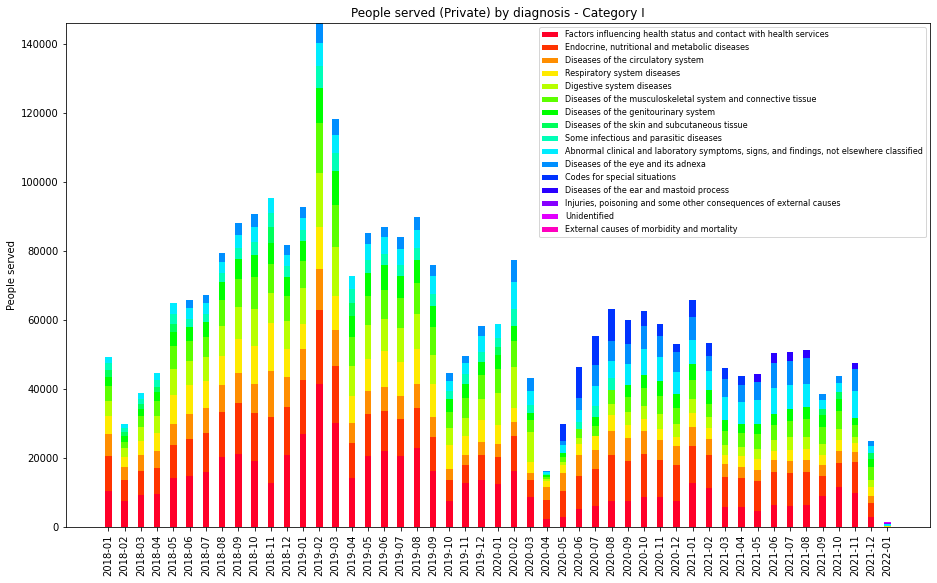

In [43]:
data_temp = all_data[all_data['CATEGORY2']==Ctgy_std]
data_temp = data_temp[data_temp['SECTOR']=='PRIVADO']

PARAMETER = 'DISEASE_GROUP'

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

# top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
# top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served (Private) by diagnosis - Category '+Ctgy_std)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1, 1), prop={'size': 8})
plt.show()

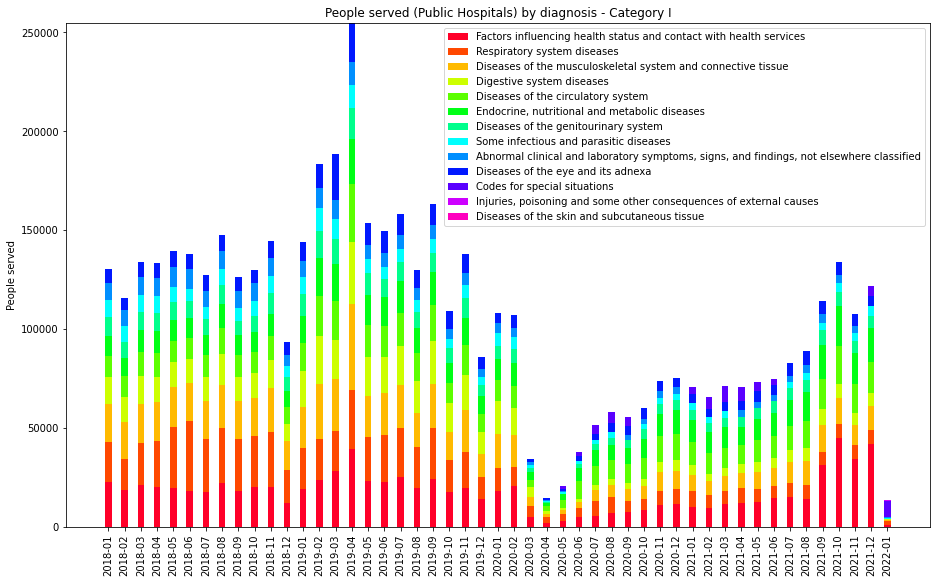

In [44]:
data_temp = all_data[all_data['CATEGORY2']==Ctgy_std]
data_temp = data_temp[~(data_temp['SECTOR']=='PRIVADO')]

PARAMETER = 'DISEASE_GROUP'

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

# top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
# top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served (Public Hospitals) by diagnosis - Category '+Ctgy_std)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1., 1))
plt.show()

/tmp/ipykernel_163925/1439161339.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_p['out'] = data_temp_p['People served'].apply(lambda x :
/tmp/ipykernel_163925/1439161339.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_d['out'] = data_temp_d['Diagnosis qty'].apply(lambda x :
/home/mnunez/.conda/envs/pycaret_ts/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

<AxesSubplot:xlabel='Diagnosis qty', ylabel='Density'>

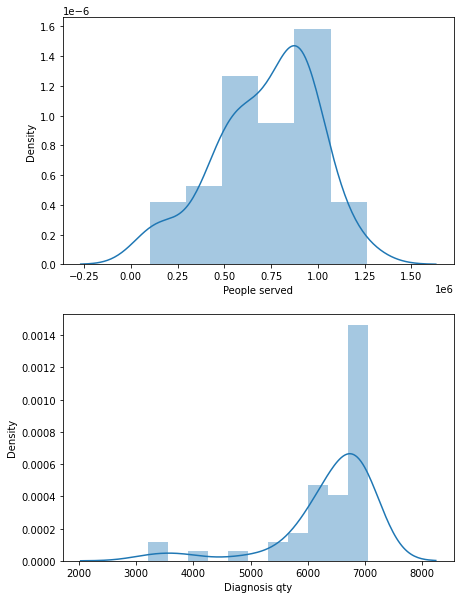

In [45]:
#### Categoria 2

Ctgy_std = 'II'
data_temp_p = data_temp_ps[data_temp_ps['CATEGORY2']==Ctgy_std]
data_temp_d = data_temp_dq[data_temp_dq['CATEGORY2']==Ctgy_std]


people_served_max = data_temp_p['People served'].mean() + 1*data_temp_p['People served'].std()
people_served_min = data_temp_p['People served'].mean() - 1*data_temp_p['People served'].std()
unique_diagnosis_max = data_temp_d['Diagnosis qty'].mean() + 1*data_temp_d['Diagnosis qty'].std()
unique_diagnosis_min = data_temp_d['Diagnosis qty'].mean() - 1*data_temp_d['Diagnosis qty'].std()

data_temp_p['out'] = data_temp_p['People served'].apply(lambda x : 
                                                           0 if (people_served_min>x or
                                                                 people_served_max<x)
                                                           else x)

data_temp_d['out'] = data_temp_d['Diagnosis qty'].apply(lambda x : 
                                                           0 if (unique_diagnosis_min>x or
                                                                 unique_diagnosis_max<x)
                                                           else x)

plt.figure(figsize=(7,10))

plt.subplot(2,1,1)
sns.distplot(data_temp_p['People served'])
plt.subplot(2,1,2)
sns.distplot(data_temp_d['Diagnosis qty'])

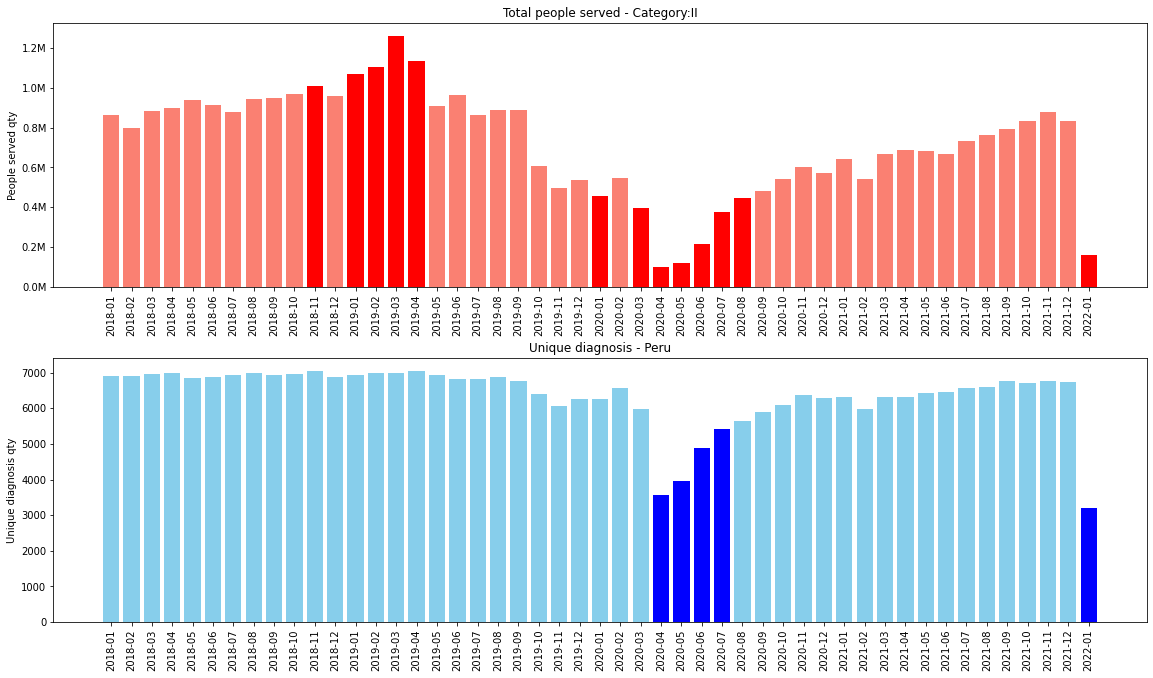

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(17,10))
fig.tight_layout(pad=5.0)

x = [str(item)[:7] for item in np.unique(data_temp_p['DATE'])]

y = list(data_temp_p['People served'])
ax[0].bar(x, y, color='red')
y = list(data_temp_p['out'])
ax[0].bar(x, y, color='salmon')
ax[0].set_ylabel('People served qty')
ax[0].set_title('Total people served - Category:'+Ctgy_std)
ax[0].set_xticks(x)
ax[0].set_xticklabels(x, rotation=90)
ax[0].yaxis.set_major_formatter(millions)

y = list(data_temp_d['Diagnosis qty'])
ax[1].bar(x, y, color='blue')
y = list(data_temp_d['out'])
ax[1].bar(x, y, color='skyblue')
ax[1].set_ylabel('Unique diagnosis qty')
ax[1].set_title('Unique diagnosis - Peru')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, rotation=90)

fig.show()

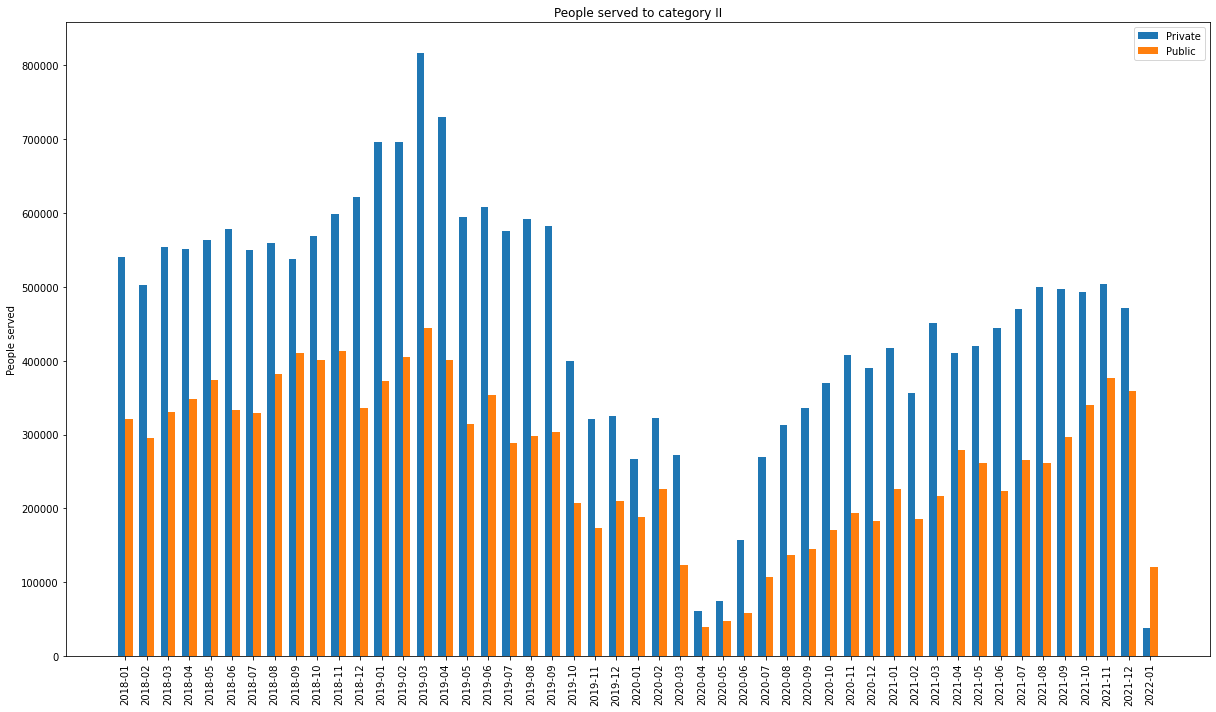

In [47]:
data_temp = all_data[all_data['CATEGORY2']==Ctgy_std]
data_temp = data_temp.groupby(['DATE','SECTOR2']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

# data_temp['QTY_PEOPLE_SERVED'] = data_temp['QTY_PEOPLE_SERVED'].mask(
#     (data_temp['DATE'].dt.year==2018) & (data_temp['DATE'].dt.month==4), 0)



date_uniques = data_temp['DATE'].unique()
data_temp_privado = data_temp[data_temp['SECTOR2']=='PRIVADO']
data_temp_publico = data_temp[data_temp['SECTOR2']=='PUBLICO']


dimension = data_temp_privado['SECTOR2'].unique()
for date in date_uniques:
    temp_df = data_temp_privado[data_temp_privado['DATE']==date]
    dimension_temp = list(set(dimension) - set(temp_df['SECTOR2'].values))
    temp_df = pd.DataFrame(dimension_temp, columns =['SECTOR2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp_privado = pd.concat([data_temp_privado, temp_df])

    
dimension = data_temp_publico['SECTOR2'].unique()
for date in date_uniques:
    temp_df = data_temp_publico[data_temp_publico['DATE']==date]
    dimension_temp = list(set(dimension) - set(temp_df['SECTOR2'].values))
    temp_df = pd.DataFrame(dimension_temp, columns =['SECTOR2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp_publico = pd.concat([data_temp_publico, temp_df])

data_temp_privado = data_temp_privado.sort_values(by=['DATE','SECTOR2'], ascending=True)
data_temp_publico = data_temp_publico.sort_values(by=['DATE','SECTOR2'], ascending=True)


labels = [str(x)[:7] for x in date_uniques]
privado_means = list(data_temp_privado['QTY_PEOPLE_SERVED'])
publico_means = list(data_temp_publico['QTY_PEOPLE_SERVED'])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

#fig, ax = plt.subplots()
fig, ax = plt.subplots(1, 1, figsize=(17,10))
rects1 = ax.bar(x - width/2, privado_means, width, label='Private')
rects2 = ax.bar(x + width/2, publico_means, width, label='Public')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('People served')
ax.set_title('People served to category '+Ctgy_std)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

#ax.yaxis.set_major_formatter(millions)

plt.show()

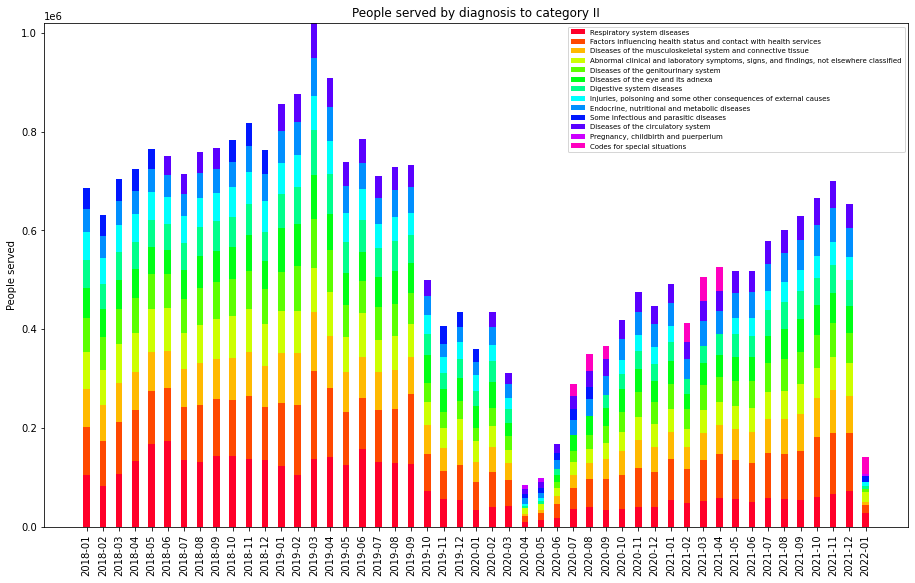

In [48]:
data_temp = all_data[all_data['CATEGORY2']==Ctgy_std]

PARAMETER = 'DISEASE_GROUP'

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    #temp_df = temp_df.reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)


# top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
# top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis to category '+Ctgy_std)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.0, 1), prop={'size': 7})
plt.show()

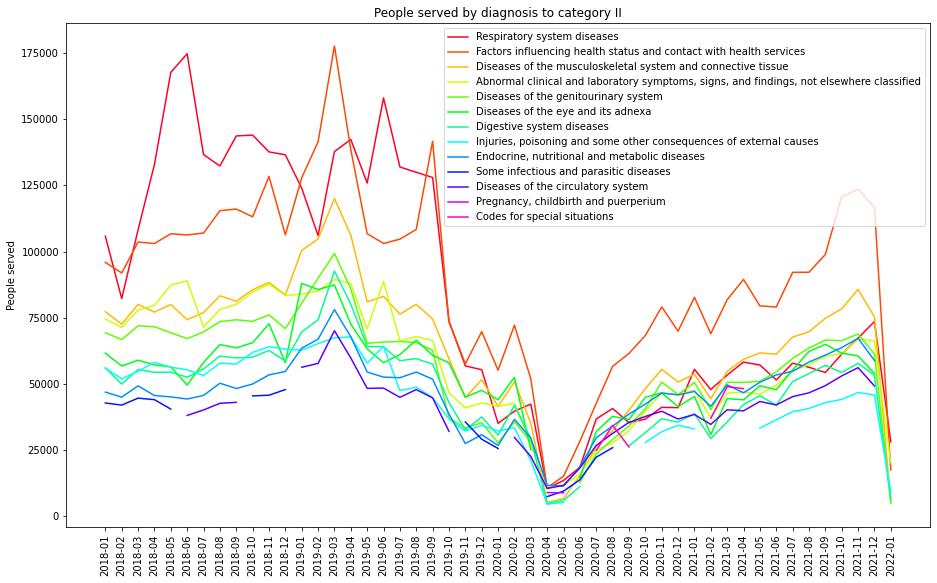

In [49]:

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])


values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    temp_df = temp_df.replace(0, np.nan)
    
    values = temp_df['QTY_PEOPLE_SERVED'].values
    #values = temp_df['PER'].values
    
    ax.plot(values, color=colors[i], label=diag)
    values_temp = values_temp + values
    i+=1
    
ax.set_ylabel('People served')
ax.set_title('People served by diagnosis to category '+Ctgy_std)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.0, 1), loc=1)
plt.show()


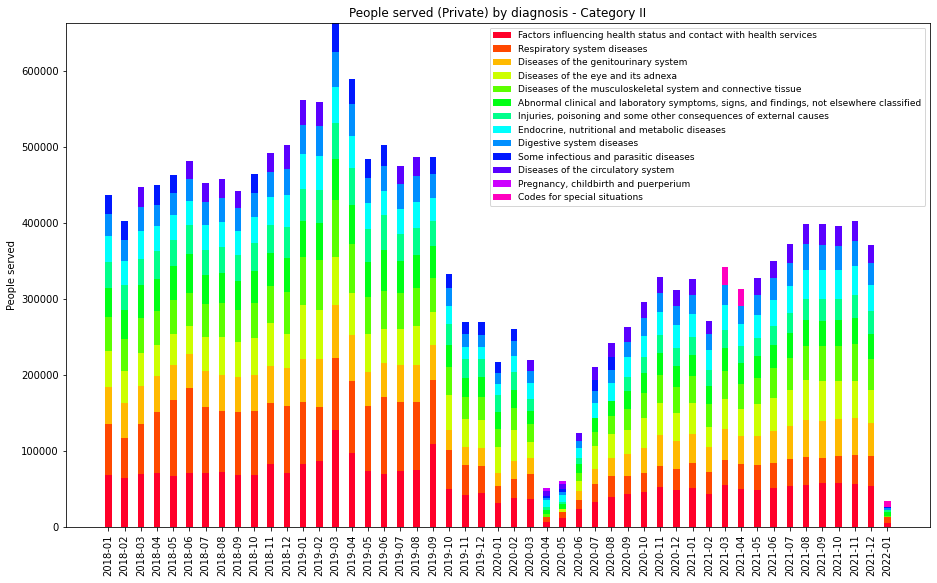

In [50]:
data_temp = all_data[all_data['CATEGORY2']==Ctgy_std]
data_temp = data_temp[data_temp['SECTOR']=='PRIVADO']

PARAMETER = 'DISEASE_GROUP'

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

# top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
# top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served (Private) by diagnosis - Category '+Ctgy_std)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1, 1), prop={'size': 9})
plt.show()

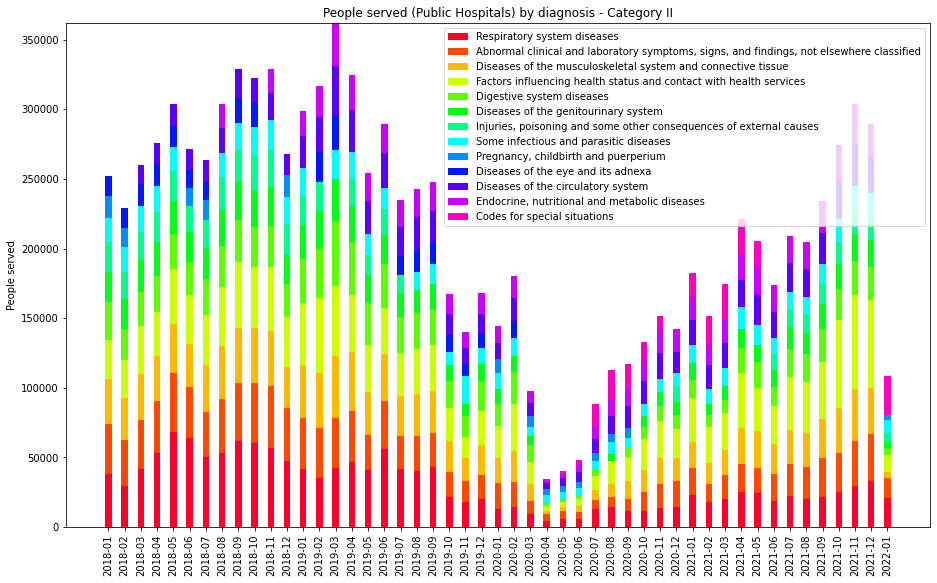

In [51]:
data_temp = all_data[all_data['CATEGORY2']==Ctgy_std]
data_temp = data_temp[~(data_temp['SECTOR']=='PRIVADO')]

PARAMETER = 'DISEASE_GROUP'

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

# top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
# top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served (Public Hospitals) by diagnosis - Category '+Ctgy_std)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, loc=1, bbox_to_anchor = (1., 1))#, prop={'size': 9})
plt.show()

/tmp/ipykernel_163925/3905900440.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_p['out'] = data_temp_p['People served'].apply(lambda x :
/tmp/ipykernel_163925/3905900440.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_d['out'] = data_temp_d['Diagnosis qty'].apply(lambda x :
/home/mnunez/.conda/envs/pycaret_ts/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

<AxesSubplot:xlabel='Diagnosis qty', ylabel='Density'>

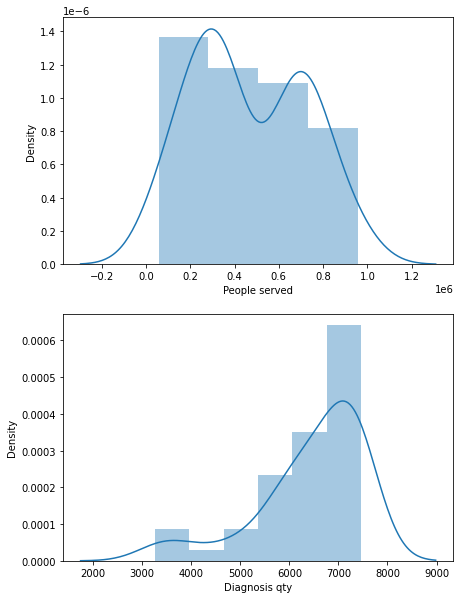

In [52]:
#### Categoria 3

Ctgy_std = 'III'
data_temp_p = data_temp_ps[data_temp_ps['CATEGORY2']==Ctgy_std]
data_temp_d = data_temp_dq[data_temp_dq['CATEGORY2']==Ctgy_std]


people_served_max = data_temp_p['People served'].mean() + 1*data_temp_p['People served'].std()
people_served_min = data_temp_p['People served'].mean() - 1*data_temp_p['People served'].std()
unique_diagnosis_max = data_temp_d['Diagnosis qty'].mean() + 1*data_temp_d['Diagnosis qty'].std()
unique_diagnosis_min = data_temp_d['Diagnosis qty'].mean() - 1*data_temp_d['Diagnosis qty'].std()

data_temp_p['out'] = data_temp_p['People served'].apply(lambda x : 
                                                           0 if (people_served_min>x or
                                                                 people_served_max<x)
                                                           else x)

data_temp_d['out'] = data_temp_d['Diagnosis qty'].apply(lambda x : 
                                                           0 if (unique_diagnosis_min>x or
                                                                 unique_diagnosis_max<x)
                                                           else x)

plt.figure(figsize=(7,10))

plt.subplot(2,1,1)
sns.distplot(data_temp_p['People served'])
plt.subplot(2,1,2)
sns.distplot(data_temp_d['Diagnosis qty'])

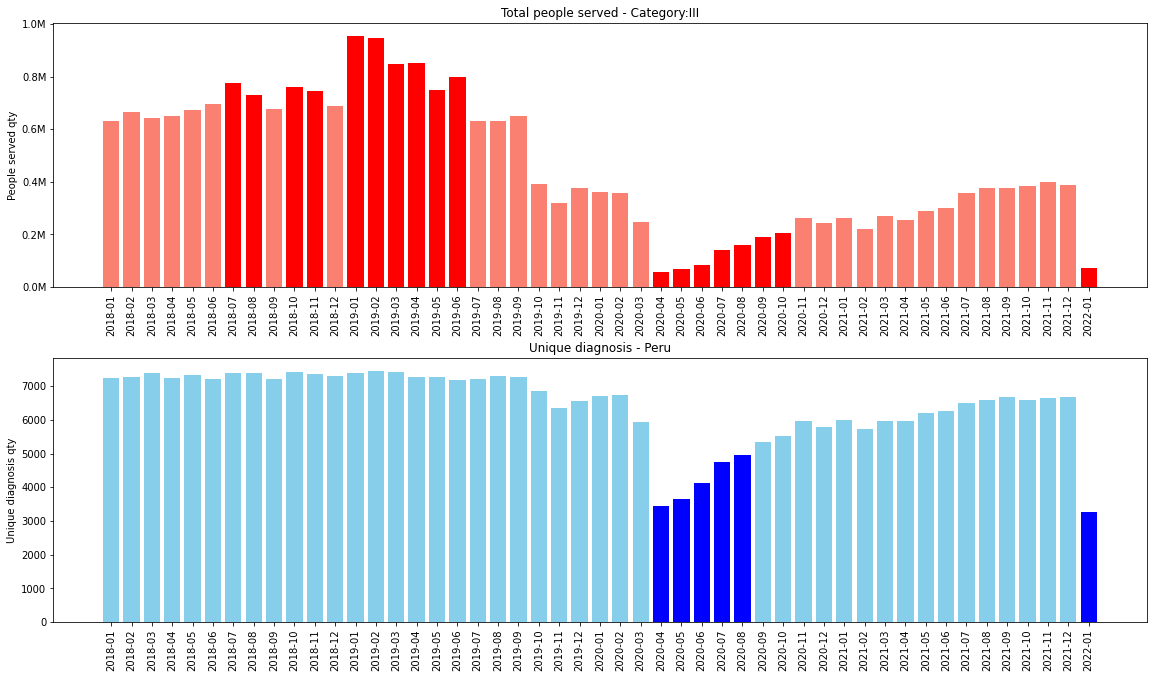

In [53]:
fig, ax = plt.subplots(2, 1, figsize=(17,10))
fig.tight_layout(pad=5.0)

x = [str(item)[:7] for item in np.unique(data_temp_p['DATE'])]

y = list(data_temp_p['People served'])
ax[0].bar(x, y, color='red')
y = list(data_temp_p['out'])
ax[0].bar(x, y, color='salmon')
ax[0].set_ylabel('People served qty')
ax[0].set_title('Total people served - Category:'+Ctgy_std)
ax[0].set_xticks(x)
ax[0].set_xticklabels(x, rotation=90)
ax[0].yaxis.set_major_formatter(millions)

y = list(data_temp_d['Diagnosis qty'])
ax[1].bar(x, y, color='blue')
y = list(data_temp_d['out'])
ax[1].bar(x, y, color='skyblue')
ax[1].set_ylabel('Unique diagnosis qty')
ax[1].set_title('Unique diagnosis - Peru')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, rotation=90)

fig.show()

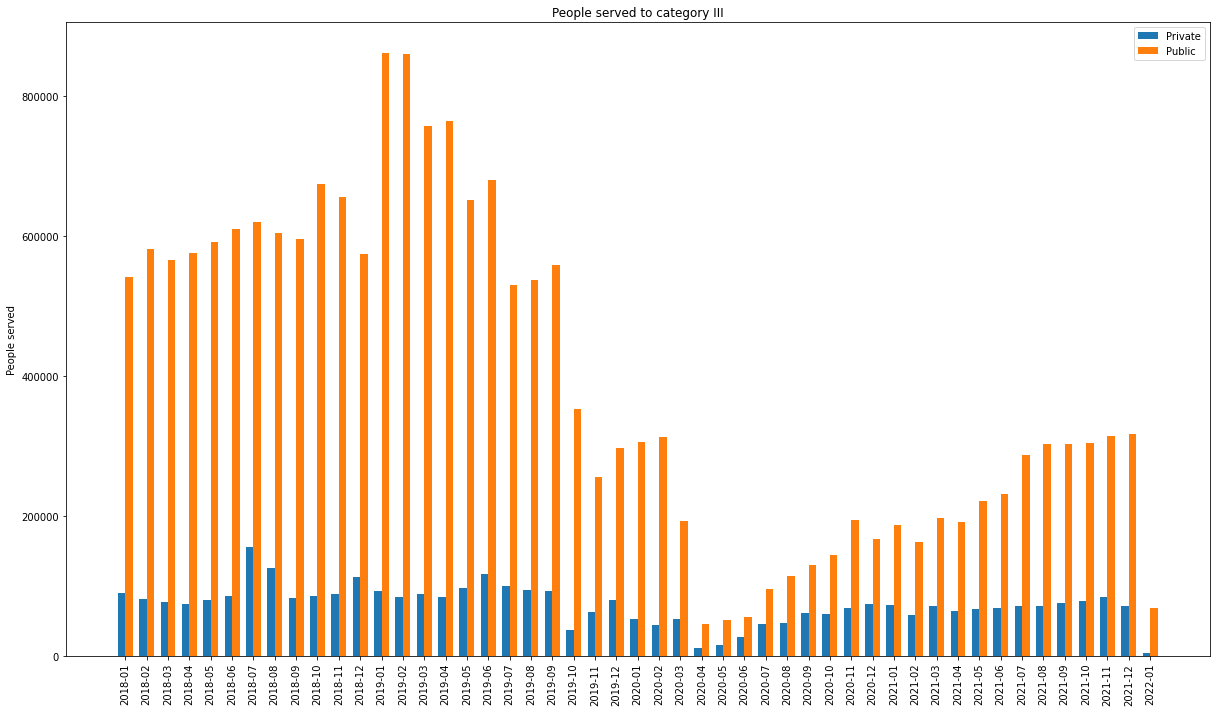

In [54]:
data_temp = all_data[all_data['CATEGORY2']==Ctgy_std]
data_temp = data_temp.groupby(['DATE','SECTOR2']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

# data_temp['QTY_PEOPLE_SERVED'] = data_temp['QTY_PEOPLE_SERVED'].mask(
#     (data_temp['DATE'].dt.year==2018) & (data_temp['DATE'].dt.month==4), 0)



date_uniques = data_temp['DATE'].unique()
data_temp_privado = data_temp[data_temp['SECTOR2']=='PRIVADO']
data_temp_publico = data_temp[data_temp['SECTOR2']=='PUBLICO']


dimension = data_temp_privado['SECTOR2'].unique()
for date in date_uniques:
    temp_df = data_temp_privado[data_temp_privado['DATE']==date]
    dimension_temp = list(set(dimension) - set(temp_df['SECTOR2'].values))
    temp_df = pd.DataFrame(dimension_temp, columns =['SECTOR2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp_privado = pd.concat([data_temp_privado, temp_df])

    
dimension = data_temp_publico['SECTOR2'].unique()
for date in date_uniques:
    temp_df = data_temp_publico[data_temp_publico['DATE']==date]
    dimension_temp = list(set(dimension) - set(temp_df['SECTOR2'].values))
    temp_df = pd.DataFrame(dimension_temp, columns =['SECTOR2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp_publico = pd.concat([data_temp_publico, temp_df])

data_temp_privado = data_temp_privado.sort_values(by=['DATE','SECTOR2'], ascending=True)
data_temp_publico = data_temp_publico.sort_values(by=['DATE','SECTOR2'], ascending=True)


labels = [str(x)[:7] for x in date_uniques]
privado_means = list(data_temp_privado['QTY_PEOPLE_SERVED'])
publico_means = list(data_temp_publico['QTY_PEOPLE_SERVED'])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

#fig, ax = plt.subplots()
fig, ax = plt.subplots(1, 1, figsize=(17,10))
rects1 = ax.bar(x - width/2, privado_means, width, label='Private')
rects2 = ax.bar(x + width/2, publico_means, width, label='Public')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('People served')
ax.set_title('People served to category '+Ctgy_std)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

#ax.yaxis.set_major_formatter(millions)

plt.show()

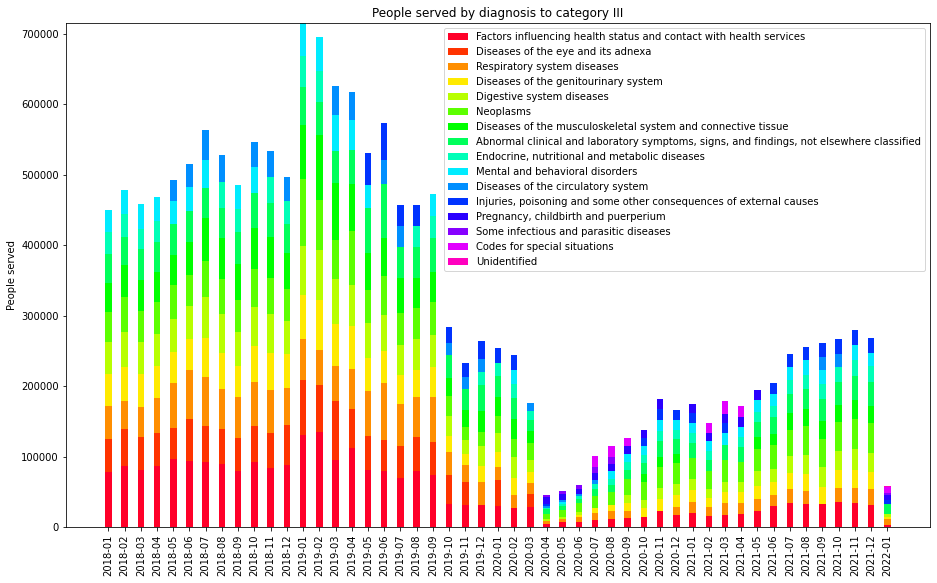

In [55]:
data_temp = all_data[all_data['CATEGORY2']==Ctgy_std]

PARAMETER = 'DISEASE_GROUP'

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    #temp_df = temp_df.reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)


# top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
# top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis to category '+Ctgy_std)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.0, 1))
plt.show()

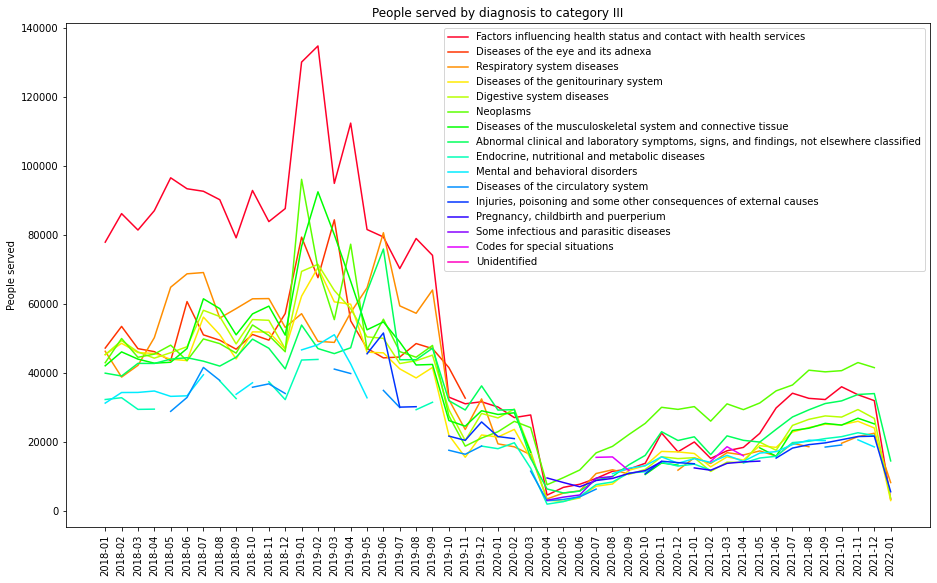

In [56]:

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])


values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    temp_df = temp_df.replace(0, np.nan)
    
    values = temp_df['QTY_PEOPLE_SERVED'].values
    #values = temp_df['PER'].values
    
    ax.plot(values, color=colors[i], label=diag)
    values_temp = values_temp + values
    i+=1
    
ax.set_ylabel('People served')
ax.set_title('People served by diagnosis to category '+Ctgy_std)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.0, 1))
plt.show()


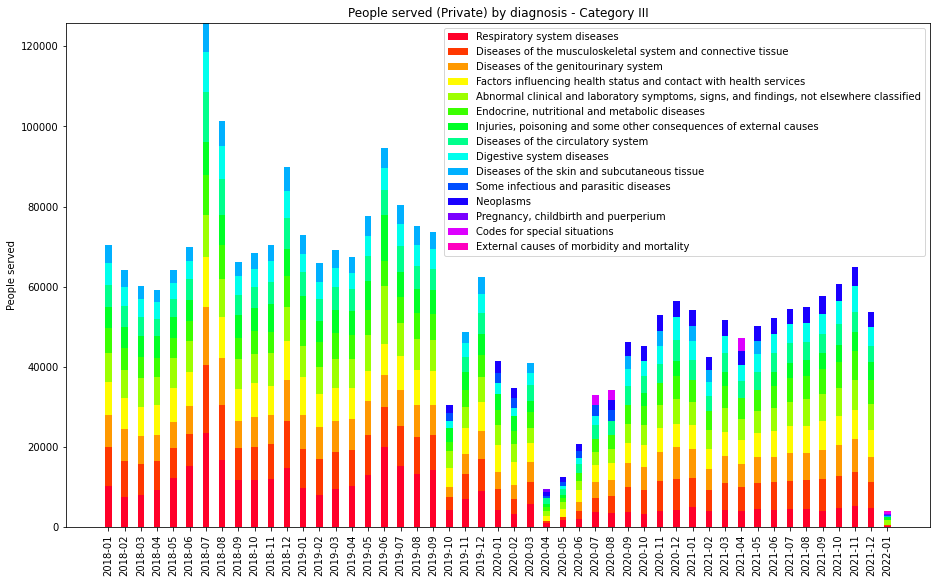

In [57]:
data_temp = all_data[all_data['CATEGORY2']==Ctgy_std]
data_temp = data_temp[data_temp['SECTOR']=='PRIVADO']

PARAMETER = 'DISEASE_GROUP'

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

# top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
# top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served (Private) by diagnosis - Category '+Ctgy_std)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1, 1))#, prop={'size': 8})
plt.show()

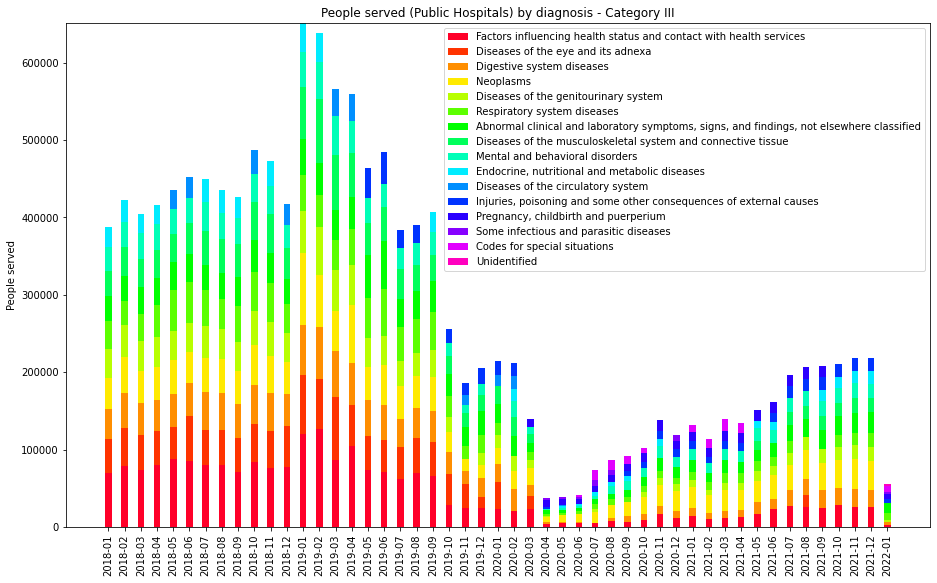

In [58]:
data_temp = all_data[all_data['CATEGORY2']==Ctgy_std]
data_temp = data_temp[~(data_temp['SECTOR']=='PRIVADO')]

PARAMETER = 'DISEASE_GROUP'

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

# top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
# top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served (Public Hospitals) by diagnosis - Category '+Ctgy_std)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1., 1))
plt.show()

### People qty by hospitals and hospital category (YEAR)

In [59]:
data_temp = all_data[all_data['CATEGORY2']!='ABC']
# data_temp = data_temp.groupby(['DATE','CATEGORY2','DIAGNOSIS_ID']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
# data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['YEAR','CATEGORY2']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['YEAR'].unique()
category2 = data_temp['CATEGORY2'].unique()

for date in date_uniques:
    temp_df = data_temp[data_temp['YEAR']==date]
    category2_temp = list(set(category2) - set(temp_df['CATEGORY2'].values))
    temp_df = pd.DataFrame(category2_temp, columns =['CATEGORY2'])
    temp_df['YEAR']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp = pd.concat([data_temp, temp_df])

data_temp = data_temp.sort_values(by=['YEAR','CATEGORY2'], ascending=True)

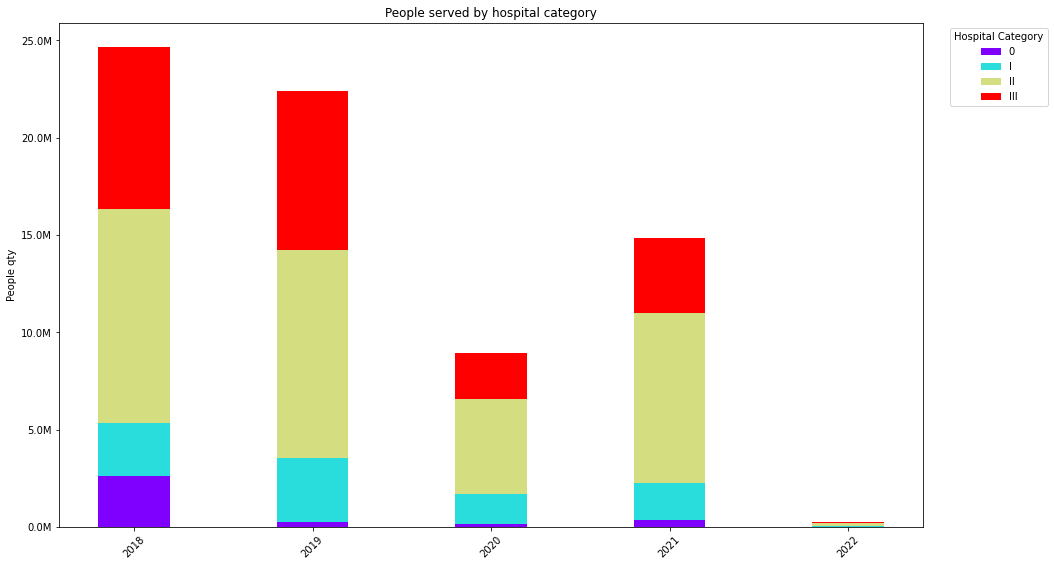

In [60]:
PARAMETER_COL = 'CATEGORY2'

category2 = data_temp[PARAMETER_COL].unique()
x_element = [str(item)[:7] for item in np.unique(data_temp['YEAR'])]
N = len(x_element)
ind = np.arange(N) 
width = 0.40

name = "rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(category2)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for p in category2:
    temp_df = data_temp[data_temp[PARAMETER_COL]==p]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People qty')
ax.set_title('People served by hospital category')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=category2, bbox_to_anchor = (1.15, 1), title = "Hospital Category")
plt.show()

### Graph by gender and hospital category

In [61]:
data_temp = all_data[all_data['CATEGORY2']!='ABC']
data_temp = data_temp.groupby(['DATE','SEX','CATEGORY2','DIAGNOSIS_ID']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE','SEX','CATEGORY2']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['DATE'].unique()
category = data_temp['CATEGORY2'].unique()

data_temp_m = data_temp[data_temp['SEX']=='M']
data_temp_f = data_temp[data_temp['SEX']=='F']

for date in date_uniques:
    temp_df = data_temp_m[data_temp_m['DATE']==date]
    category_temp = list(set(category) - set(temp_df['CATEGORY2'].values))
    temp_df = pd.DataFrame(category_temp, columns =['CATEGORY2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp_m = pd.concat([data_temp_m, temp_df])

for date in date_uniques:
    temp_df = data_temp_f[data_temp_f['DATE']==date]
    category_temp = list(set(category) - set(temp_df['CATEGORY2'].values))
    temp_df = pd.DataFrame(category_temp, columns =['CATEGORY2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp_f = pd.concat([data_temp_f, temp_df])

data_temp_m = data_temp_m.sort_values(by=['DATE','CATEGORY2'], ascending=True)
data_temp_f = data_temp_f.sort_values(by=['DATE','CATEGORY2'], ascending=True)

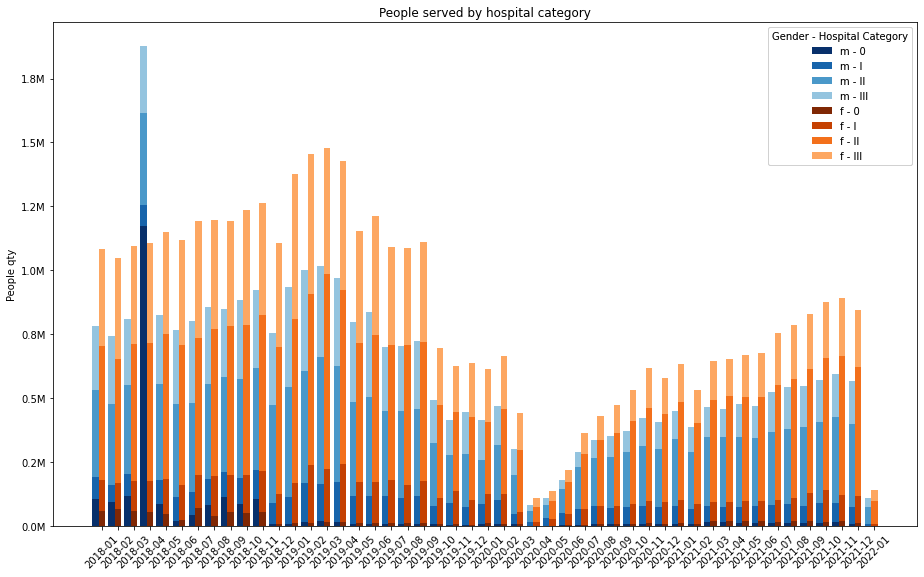

In [62]:
PARAMETER_COL = 'CATEGORY2'

category_m = data_temp_m[PARAMETER_COL].unique()
category_f = data_temp_f[PARAMETER_COL].unique()
x_element = [str(item)[:7] for item in np.unique(data_temp_m['DATE'])]
N = len(x_element)
ind = np.arange(N) 
width = 0.5*0.8

name = "Blues"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors_m = cmap(list(reversed(np.linspace(0, 1, len(category_m)+2))))

name = "Oranges"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors_f = cmap(list(reversed(np.linspace(0, 1, len(category_f)+2))))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

tags =[]
values_temp_m = 0
i = 0
for p in category_m:
    tag = 'm - '+p
    temp_df = data_temp_m[data_temp_m[PARAMETER_COL]==p]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind - width, values, width, bottom=values_temp_m, color=colors_m[i])
    values_temp_m = values_temp_m + values
    i+=1
    tags.append(tag)
    
values_temp_f = 0
i = 0
for p in category_f:
    tag = 'f - '+p
    temp_df = data_temp_f[data_temp_f[PARAMETER_COL]==p]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind + 0, values, width, bottom=values_temp_f, color=colors_f[i])
    values_temp_f = values_temp_f + values
    i+=1
    tags.append(tag)

ax.set_ylabel('People qty')
ax.set_title('People served by hospital category')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)



# legend1 = plt.legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc=1)
# legend2 = plt.legend([lines[i] for i in [2,3]],['manual label 3','manual label 4'], loc=4)
# plt.gca().add_artist(legend1)

# legend1 = ax.legend(labels=category_m, color = colors_f, bbox_to_anchor = (1.0, 1), title = "Hospital Category - male  ")
# legend2 = ax.legend(labels=category_f, bbox_to_anchor = (1, 0.8), title = "Hospital Category - female")
# ax.add_artist(legend1)
# ax.add_artist(legend2)

legend1 = ax.legend(labels=tags, bbox_to_anchor = (1.0, 1), title = "Gender - Hospital Category")
ax.add_artist(legend1)

plt.show()

### Proyeccion del sistemas por genero

In [63]:
data_temp = all_data[all_data['CATEGORY2']!='ABC']
data_temp = data_temp.groupby(['DATE','SEX']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['DATE'].unique()
data_temp_m = data_temp[data_temp['SEX']=='M']
data_temp_f = data_temp[data_temp['SEX']=='F']


dimension = data_temp_m['SEX'].unique()
for date in date_uniques:
    temp_df = data_temp_m[data_temp_m['DATE']==date]
    dimension_temp = list(set(dimension) - set(temp_df['SEX'].values))
    temp_df = pd.DataFrame(dimension_temp, columns =['SEX'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp_m = pd.concat([data_temp_m, temp_df])

    
dimension = data_temp_f['SEX'].unique()
for date in date_uniques:
    temp_df = data_temp_f[data_temp_f['DATE']==date]
    dimension_temp = list(set(dimension) - set(temp_df['SEX'].values))
    temp_df = pd.DataFrame(dimension_temp, columns =['SEX'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp_f = pd.concat([data_temp_f, temp_df])

data_temp_m = data_temp_m.sort_values(by=['DATE','SEX'], ascending=True)
data_temp_f = data_temp_f.sort_values(by=['DATE','SEX'], ascending=True)

In [64]:
labels = [str(x)[:7] for x in date_uniques]
men_means = list(data_temp_m['QTY_PEOPLE_SERVED'])
women_means = list(data_temp_f['QTY_PEOPLE_SERVED'])

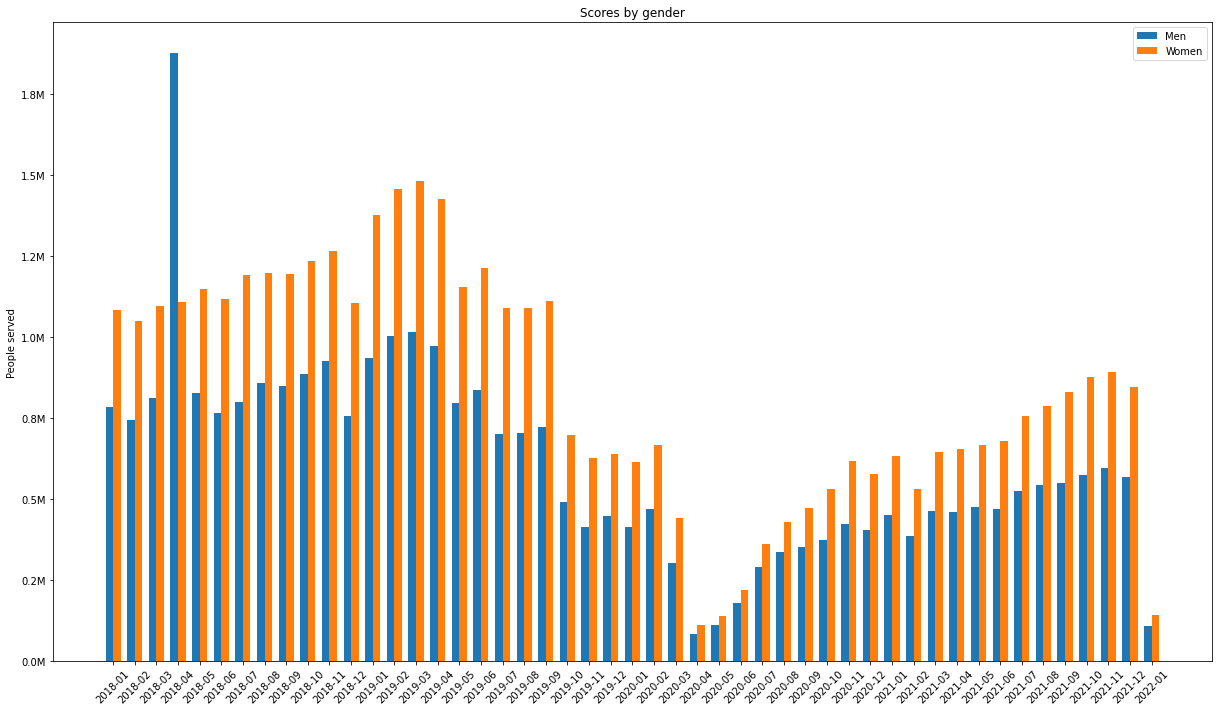

In [65]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

#fig, ax = plt.subplots()
fig, ax = plt.subplots(1, 1, figsize=(17,10))
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('People served')
ax.set_title('Scores by gender')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

ax.yaxis.set_major_formatter(millions)

plt.show()

### Dental diagnosis

In [66]:
data_temp = all_data
data_temp['DENTAL_DISEASE'] = data_temp['DIAGNOSIS_ID'].str.contains('^K')

data_temp = data_temp.groupby(['YEAR','DENTAL_DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.sort_values(by=['YEAR', 'DENTAL_DISEASE']).reset_index()
data_temp = data_temp.pivot(index =['YEAR'], columns = 'DENTAL_DISEASE')
data_temp.columns = data_temp.columns.droplevel()
data_temp.fillna(0, inplace = True)
data_temp.head()

DENTAL_DISEASE,False,True
YEAR,,
2018,22995488,1678759
2019,20709480,1685681
2020,8351370,572040
2021,13923488,933330
2022,239586,10533


Text(0.5, 1.0, 'Qty of dental diseases by year')

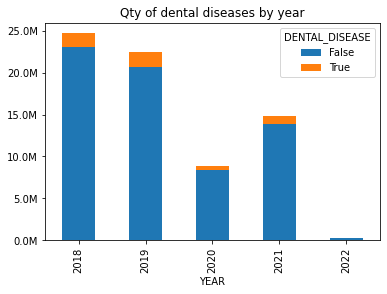

In [67]:
abc = data_temp.plot(kind="bar", stacked=True)
abc.yaxis.set_major_formatter(millions)
abc.set_title('Qty of dental diseases by year')

In [68]:
data_temp = data_temp.reset_index()
data_temp['total'] = data_temp[False] + data_temp[True]
data_temp[False] = data_temp[False]/data_temp['total']
data_temp[True] = data_temp[True]/data_temp['total']
del data_temp['total']

data_temp = data_temp.set_index('YEAR')

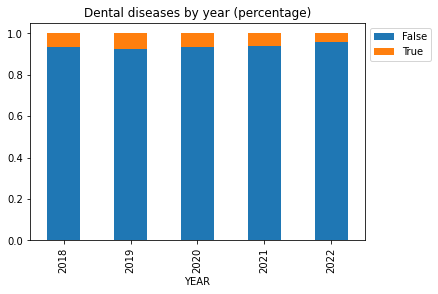

In [69]:
abc = data_temp.plot(kind="bar", stacked=True)
#abc.yaxis.set_major_formatter(millions)
abc.set_title('Dental diseases by year (percentage)')

abc.legend(bbox_to_anchor = (1.0, 1))

### Conteo de diagnosticos por mes jensenshannon_dis

In [70]:

# DISEASE_GROUP, DIAGNOSIS_ID

data_temp = all_data[all_data['CATEGORY2']!='ABC']
data_temp = data_temp.groupby(['DATE','DISEASE_GROUP']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['DATE'].unique()
dimension = data_temp['DISEASE_GROUP'].unique()

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    dimension_temp = list(set(dimension) - set(temp_df['DISEASE_GROUP'].values))
    temp_df = pd.DataFrame(dimension_temp, columns =['DISEASE_GROUP'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp = pd.concat([data_temp, temp_df])
    
data_temp = data_temp.sort_values(by=['DATE','DISEASE_GROUP'], ascending=True)

In [71]:
data_temp.head()

,DATE,DISEASE_GROUP,QTY_PEOPLE_SERVED
0,2018-01-01,"Abnormal clinical and laboratory symptoms, sig...",132370
1,2018-01-01,Codes for special situations,103
2,2018-01-01,"Congenital malformations, deformities and chro...",14966
3,2018-01-01,Digestive system diseases,136278
4,2018-01-01,Diseases of the blood and hematopoietic organs...,16710


In [72]:
diseases_dim = []
diseases_name = []
for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    diseases_name.append(list(temp_df['DISEASE_GROUP']))
    diseases_dim.append(list(temp_df['QTY_PEOPLE_SERVED']))

In [73]:
from scipy.spatial import distance

jensenshannon_dis = []
for i in range(len(date_uniques)-1):
    i_date = str(date_uniques[i])[:7]
    f_date = str(date_uniques[i+1])[:7]
    dis = distance.jensenshannon(diseases_dim[i], diseases_dim[i+1])
    jensenshannon_dis.append([i_date, f_date, dis])
    
jensenshannon_dis = pd.DataFrame(jensenshannon_dis,
                                 columns =['date_i', 'date_f', 'jensenshannon'])

In [74]:
jensenshannon_dis.head()

,date_i,date_f,jensenshannon
0,2018-01,2018-02,0.024313
1,2018-02,2018-03,0.022876
2,2018-03,2018-04,0.310843
3,2018-04,2018-05,0.318266
4,2018-05,2018-06,0.024077


/tmp/ipykernel_163925/3424621862.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(jensenshannon_dis['date_f'], rotation=45)


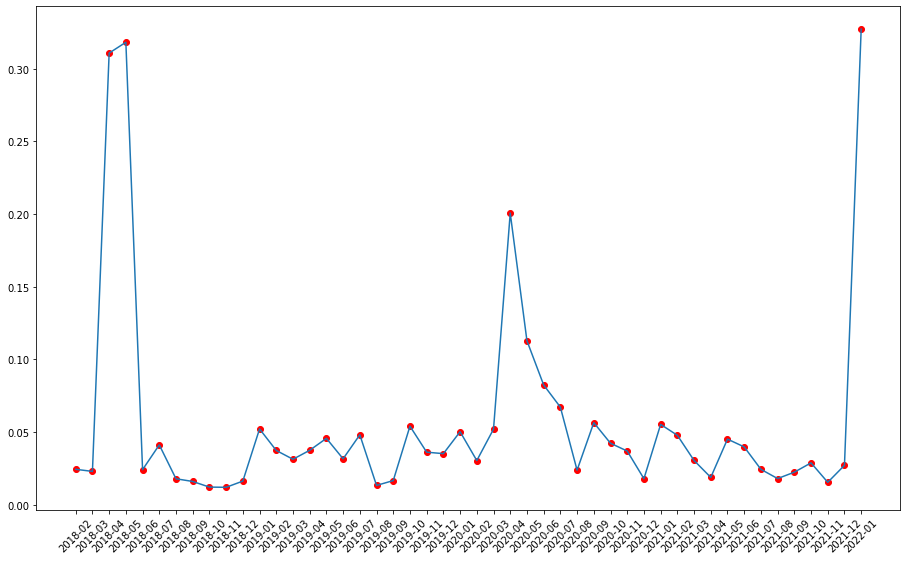

In [75]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

ax.plot(jensenshannon_dis['date_i'], jensenshannon_dis['jensenshannon'], 'ro')
ax.plot(jensenshannon_dis['date_i'], jensenshannon_dis['jensenshannon'], '-')
#ax.bar(jensenshannon_dis['date_i'], jensenshannon_dis['jensenshannon'])
ax.set_xticklabels(jensenshannon_dis['date_f'], rotation=45)
plt.show()

### Cholera, skin damage chicunguya, malaria, sika

In [76]:
def temp_funct(x):
    x = x[0:3]
    if x in ['P35']:
        return 'Zika'
    elif x in ['P37', 'B50', 'B51', 'B52', 'B53', 'B54']:
        return 'Malaria'
    elif x in ['A00']:
        return 'Cholera'
    elif x in ['A92']:
        return 'Chikungunya '
    else:
        return 'Other'
    return 'Other'

In [77]:
data_temp = all_data
data_temp['INFECTIONS_DISEASE'] = data_temp['DIAGNOSIS_ID'].apply(lambda x:temp_funct(x))
data_temp = data_temp[data_temp['INFECTIONS_DISEASE']!='Other']

data_temp = data_temp.groupby(['YEAR','INFECTIONS_DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.sort_values(by=['YEAR', 'INFECTIONS_DISEASE']).reset_index()
data_temp = data_temp.pivot(index =['YEAR'], columns = 'INFECTIONS_DISEASE')
data_temp.columns = data_temp.columns.droplevel()
data_temp.fillna(0, inplace = True)
data_temp.head()

INFECTIONS_DISEASE,Chikungunya,Cholera,Malaria,Zika
YEAR,,,,
2018,45.0,251.0,929.0,206.0
2019,50.0,692.0,615.0,149.0
2020,9.0,67.0,195.0,41.0
2021,7.0,206.0,241.0,90.0
2022,0.0,0.0,4.0,4.0


Text(0.5, 1.0, 'Qty of diseases by year')

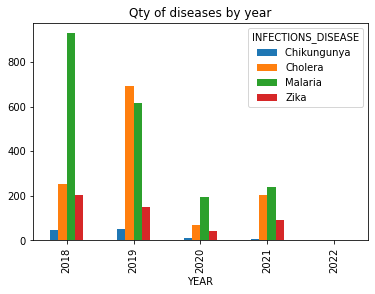

In [78]:
abc = data_temp.plot(kind="bar", stacked=False)
#abc.yaxis.set_major_formatter(millions)
abc.set_title('Qty of diseases by year')

### Ask the codes Pneumonia, influenza.
    - ICD-10-CM Code for Pneumonia, unspecified organism J18.9
    - Influenza and pneumonia (J09-J18)
    - https://icd.who.int/browse10/2019/en#/J09-J18

In [79]:
def temp_funct(x):
    x = x[0:3]
    if x >= 'J09' and x < 'J12':
        return 'Influenza'
    elif x >= 'J12' and x < 'J19':
        return 'Pneumonia'
    else:
        return 'Other'
    return 'Other'

data_temp = all_data
data_temp['LUNG_DISEASE'] = data_temp['DIAGNOSIS_ID'].apply(lambda x:temp_funct(x))
data_temp = data_temp[data_temp['LUNG_DISEASE']!='Other']

data_temp = data_temp.groupby(['YEAR','LUNG_DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.sort_values(by=['YEAR', 'LUNG_DISEASE']).reset_index()
data_temp = data_temp.pivot(index =['YEAR'], columns = 'LUNG_DISEASE')
data_temp.columns = data_temp.columns.droplevel()
data_temp.fillna(0, inplace = True)
data_temp.head()

LUNG_DISEASE,Influenza,Pneumonia
YEAR,,
2018,2949,59900
2019,2196,33149
2020,471,44016
2021,750,61069
2022,76,1392


Text(0.5, 1.0, 'Qty of diseases by year')

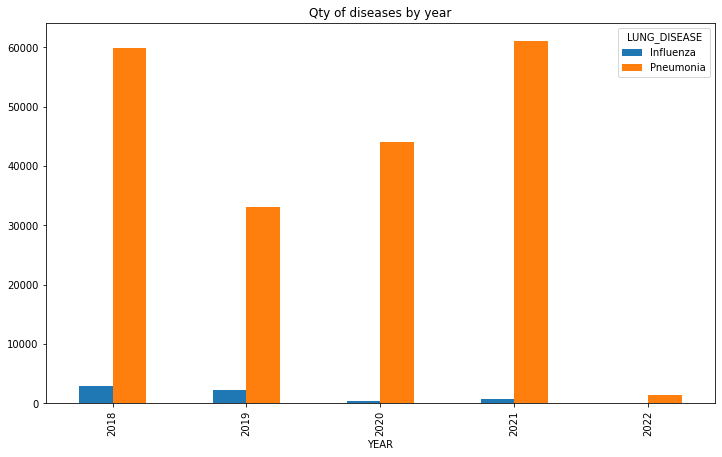

In [80]:
abc = data_temp.plot(kind="bar", stacked=False, figsize=(12,7))
#abc.yaxis.set_major_formatter(millions)
abc.set_title('Qty of diseases by year')

### Years VS (2018-2019)

In [81]:
# data_temp = all_data.groupby(['DATE','SEX']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
# data_temp = data_temp.reset_index()

date_uniques = all_data['MONTH'].unique()

data_temp_m = all_data[all_data['YEAR']==2018]
data_temp_m = data_temp_m.groupby(['MONTH']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp_m = data_temp_m.rename(columns={'QTY_PEOPLE_SERVED': 'People_served_2018'})

data_temp_f = all_data[all_data['YEAR']==2019]
data_temp_f = data_temp_f.groupby(['MONTH']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp_f = data_temp_f.rename(columns={'QTY_PEOPLE_SERVED': 'People_served_2019'})

data_temp_g = all_data[all_data['YEAR']==2020]
data_temp_g = data_temp_g.groupby(['MONTH']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp_g = data_temp_g.rename(columns={'QTY_PEOPLE_SERVED': 'People_served_2020'})

data_temp_l = all_data[all_data['YEAR']==2021]
data_temp_l = data_temp_l.groupby(['MONTH']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp_l = data_temp_l.rename(columns={'QTY_PEOPLE_SERVED': 'People_served_2021'})

object_df = pd.merge(data_temp_m, data_temp_f, how='inner', on=('MONTH'))
object_df = pd.merge(object_df, data_temp_g, how='inner', on=('MONTH'))
object_df = pd.merge(object_df, data_temp_l, how='inner', on=('MONTH'))

object_df.head()

,People_served_2018,People_served_2019,People_served_2020,People_served_2021
MONTH,,,,
1,1865409,2310921,1026985,1083959
2,1794168,2458457,1134259,917967
3,1906675,2495033,745111,1108888
4,2983260,2397163,192893,1114314
5,1976273,1951960,249910,1143498


Text(0.5, 1.0, 'Qty of diseases by month')

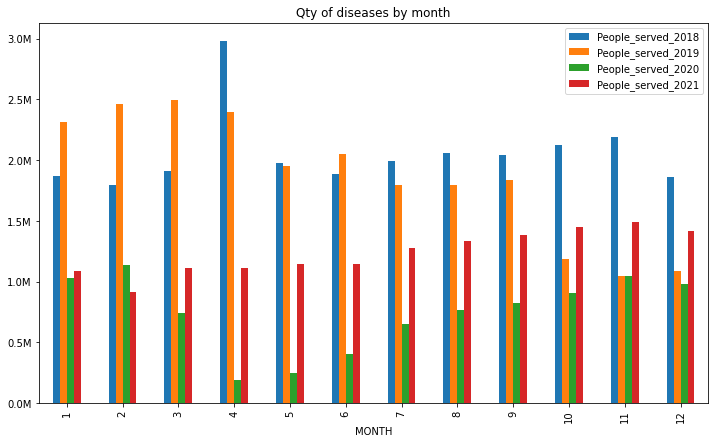

In [82]:
abc = object_df.plot(kind="bar", stacked=False, figsize=(12,7))
abc.yaxis.set_major_formatter(millions)
abc.set_title('Qty of diseases by month')

In [83]:
all_data.head()

,DATE,YEAR,MONTH,STATE,PROVINCE,DISTRICT,SECTOR,CATEGORY,CATEGORY2,CO_IPRESS,...,DISEASE_GROUP,COD_IPRESS,x,y,SECTOR_R,TYPE,SECTOR2,DENTAL_DISEASE,INFECTIONS_DISEASE,LUNG_DISEASE
0,2021-12-01,2021,12,LIMA,LIMA,LOS OLIVOS,PRIVADO,II-E,II,00023151,...,Diseases of the genitourinary system,00023151,-11.99116,-77.073203,PRIVADO,Outpatient Consultation,PRIVADO,False,Other,Other
1,2021-12-01,2021,12,LIMA,LIMA,LOS OLIVOS,PRIVADO,II-E,II,00023151,...,Diseases of the genitourinary system,00023151,-11.99116,-77.073203,PRIVADO,Outpatient Consultation,PRIVADO,False,Other,Other
2,2021-12-01,2021,12,LIMA,LIMA,LOS OLIVOS,PRIVADO,II-E,II,00023151,...,Diseases of the genitourinary system,00023151,-11.99116,-77.073203,PRIVADO,Outpatient Consultation,PRIVADO,False,Other,Other
3,2021-12-01,2021,12,LIMA,LIMA,LOS OLIVOS,PRIVADO,II-E,II,00023151,...,Diseases of the genitourinary system,00023151,-11.99116,-77.073203,PRIVADO,Outpatient Consultation,PRIVADO,False,Other,Other
4,2021-12-01,2021,12,LIMA,LIMA,LOS OLIVOS,PRIVADO,II-E,II,00023151,...,Diseases of the genitourinary system,00023151,-11.99116,-77.073203,PRIVADO,Outpatient Consultation,PRIVADO,False,Other,Other


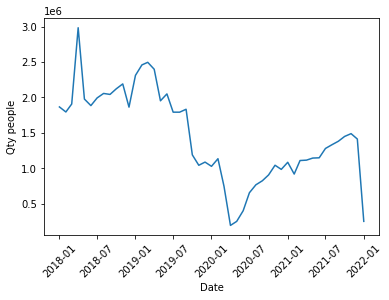

In [84]:
#all_data['DATE'] = pd.to_datetime(all_data['DATE'], format='%Y-%m-%d')

data_temp = all_data.groupby(['DATE','DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE']).agg({ 'QTY_PEOPLE_SERVED': ['sum', 'count']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()

plt.ylabel('Qty people')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(data_temp['DATE'], data_temp['sum'])

data_temp = data_temp[(data_temp['DATE']<'2022')]
data_temp_mean = data_temp[~(data_temp['DATE']>='2020-03')]
data_temp = data_temp[(data_temp['DATE']>='2020-03')]


Media: 1893486.6153846155


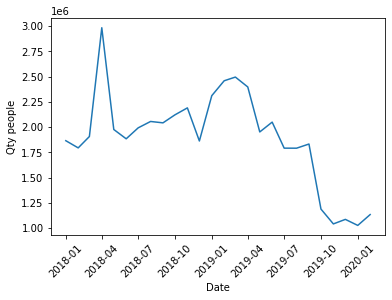

In [85]:
#data_temp_mean
plt.ylabel('Qty people')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(data_temp_mean['DATE'], data_temp_mean['sum'])

media = data_temp_mean['sum'].mean()
print('Media:',media)

In [86]:
data_temp_mean.describe()

,sum,count
count,2.600000e+01,26.000000
mean,1.893487e+06,6689.769231
std,4.802461e+05,204.040252
min,1.026985e+06,6133.000000
25%,1.792249e+06,6688.500000
50%,1.929318e+06,6765.500000
75%,2.105010e+06,6808.250000
max,2.983260e+06,6893.000000


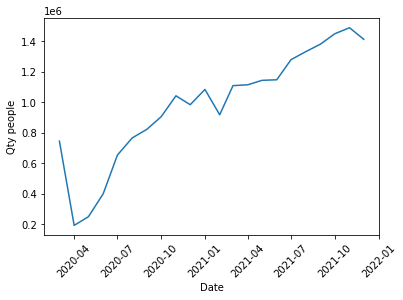

In [87]:
data_temp = data_temp[(data_temp['DATE']<'2022')]
data_temp = data_temp[(data_temp['DATE']>='2020-03')]

plt.ylabel('Qty people')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(data_temp['DATE'], data_temp['sum'])


In [88]:
data_temp = data_temp[['DATE','sum']]
data_temp = data_temp.reset_index(drop=True)
data_temp.set_index('DATE', inplace=True)
data_temp.head()

,sum
DATE,
2020-03-01,745111
2020-04-01,192893
2020-05-01,249910
2020-06-01,399843
2020-07-01,654142


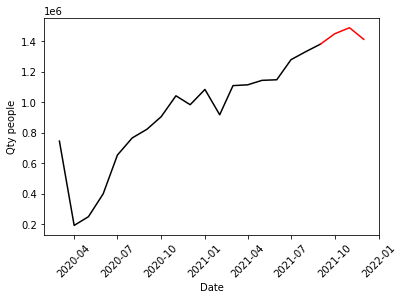

In [89]:
train = data_temp[data_temp.index < "2021-10-01"]
test = data_temp[data_temp.index >= "2021-09"]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Qty people')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

In [90]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

y = data_temp['sum']
ARIMAmodel = ARIMA(y, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

/home/mnunez/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/mnunez/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/mnunez/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


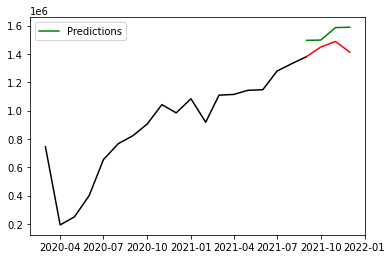

In [91]:
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.legend()

### como la demanda ha cambiado por el covid

In [92]:
data_temp.columns

Index(['sum'], dtype='object')

In [93]:
plt.hist(data_temp['CATEGORY'])

KeyError: 'CATEGORY'

In [ ]:
PARAMETER = 'CATEGORY'
data_temp = data_temp[data_temp['IS_LIMA']==True]

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

In [ ]:
all_data.head()

In [ ]:
### Hospital by category

In [ ]:
data_temp = data_temp[data_temp['IS_LIMA']==True]

data_temp = data_temp.groupby(['DATE', 'CATEGORY', 'NAME']).agg({ 'QTY_PEOPLE_SERVED': "count"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE', 'CATEGORY']).agg({ 'NAME': "count"})
data_temp = data_temp.reset_index()

In [ ]:
data_temp.head()

In [ ]:
# TODO 
# - Check outliers systematically (for each variable mean and std dev to mark points outside the the std dev) For unique giasnosis and served people
# - Hospital  per category type
# - Cholera, skin damage chicunguya, malaria, sika (look for)
# - Understand what have changed in data
# - Predict when the Peruvian health system will recover using  individuals served by month 
# - Croos by gender recovery health system using  individuals served by month 
# - Check dental diagnosis over years
# - Unique diagnosis per category type per year
# - How demand patterns change during covid-19


In [ ]:
all_data.head()

In [ ]:
abc  = all_data['DISEASE_GROUP'].unique()
abc

In [ ]:
len(abc)

In [ ]:


#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.jensenshannon.html

In [ ]:
private vs public using boostrapo
same color for all desisises
for all categories (public and private)
repet these graph for every, histogram for each category (*)
only for hospital that have diagnostics
start to agg, grup biy diagnostics


for category 2 ans 3 normalize 

build forecast for all categories


